# Datapipeline:

The sole purpose of this script is to process and prepare data from the original EEA source for modeling. This involves making logical and statistical decisions regarding the handling of missing values, outliers, and the deletion of specific columns, years, and rows. These considerations are explained in more detail in Report3_Final_Nov8.pdf.

WARNING:
Data: 
+ For the script to work the data files must be positiong in the data path of the repository or in a mounted google drive folder (which is practical if the script is executed in colab)
+ The *Data which is used : *EU_all_current_shared_Okt_23.parquet* from the original source of EEA: https://www.eea.europa.eu/en/datahub/datahubitem-view/fa8b1229-3db6-495d-b18e-9c9b3267c02b

# Steps conducted: 

0. Load the Data

* Load the data from a specified file using the appropriate function.
* Save the loaded data into a variable (called df) for further use.

1. Main data pipeline
Treat data to reach a point were we have the data frame ready for the separate treatments for classification and regression treatment



All functions can be seen with description in the utils_co2.py function conglomeration
This will be done in the summary of data treatment
- taking the dataframe coming from renaming/mapping categories above
- drop rows without target values
- declare and drop irrelevant columns
- filter df by year (default everything after 2018)
+ Identify electric cars
+ identify electric (or hybrid) cars by looking at electric range and electric capacity
+ making separate column whichs marks the non electric cars
+ fill then all the nan values in electri range and electric capacity with 0 (because they have non, which is equal to 0)
- Outlier handling
- Outlier handling function (IQR factor ab dem als Outlier gewertet wird)
- Zusätzlich in die Funktion: ersetzen durch median oder row delete
+ give to the next steps








* 1.A: Omitting / deleting of variables which have no meaning for the model (explain why)
* 1.B: Omitting / deleting car identifiers because they are not relevant for the model
* 1.C: Omitting data before a certain year (explain why)
* 1.D: Treatment of outliers (explaing why)
    * Mean for gaussian like data
    * Other technique for non gaussian distributed data
* 1.E: Separation into electric cars and non electric cars (explain why)


# Importing necessary libraries

In [ ]:
# Import the required libraries

# Data manipulation and math operations
import pandas as pd
import numpy as np
import re
import pyarrow.parquet as pq  # For working with parquet files

# Visualization libraries
import matplotlib.pyplot as plt  # For Matplotlib visualizations
import seaborn as sns            # For Seaborn visualizations
#import plotly.express as px      # For interactive visualizations with Plotly
# %matplotlib inline  # Uncomment for Jupyter notebooks to display plots inline

# System libraries
import warnings
import sys
import os
# Ignore all warnings (useful for ignoring non-critical warnings)
warnings.filterwarnings("ignore")

# Add the src directory to the system path
src_path = os.path.abspath(os.path.join('..', 'src'))
# for g-colab a cloned repo under MyDrive is assumed : /
if os.getcwd() == "/content": src_path =  "/content/drive/MyDrive/aug24_bds_int---co2/src"
if src_path not in sys.path: sys.path.append(src_path)

# Import utils library with custom functions
from utils_CO2 import *

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 0. Additional functions in between: Load, Save, Inspect - DFs

In [ ]:
# Path to the neighboring 'data' folder in the local repository
data_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'data'))


0.C Define inspeciton function

In [ ]:
# The beginning of each section
# Loading the data frame
# Inspect the data frame
df = load_data_local('EU_all_current_shared_Okt_23.parquet', data_path)

inspect_data(df)

# 1.A Initial loading and processing of Raw Data

## Loading individual years

In [ ]:
# This is the routine that was used to convert the csvs of all years one by one

# 1. Read Dataframe from csv and specify datatypes

# 2. Optimize dataypes for memory usage

# 3. Fill all missing values in all columns with nanplaceholder
# This seemed necessary in order to be able to compare rows to count and remove duplicates. I encountered
# problems before: the comparison didnt work because NaN != NaN

# 4. Count number of identical occurences and write in new column, then remove dupes to save space

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# set option so that e.g. df.head() will show all columns and none are omitted 
pd.set_option('display.max_columns', None)

import os
print("Current working directory: ", os.getcwd())

# Specify the year
year = "2022"  # Change this to the desired year

# Define file paths based on the year
csv_file_path = f"..\\Data\\EU\\EU {year}.csv"
parquet_file_path = f"..\\Data\\EU\\EU {year}_dtypes.parquet"
parquet_nanplaceholder_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder.parquet"
parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"

# 1. Read Dataframe from csv and specify datatypes. "category" for all string values reduces memory usage a lot.
df = pd.read_csv(csv_file_path, dtype={
    'ID': 'Int32',
    'Country': 'category',
    'VFN': 'category',
    'Mp': 'category',
    'Mh': 'category',
    'Man': 'category',
    'MMS': 'category',
    'Tan': 'category',
    'T': 'category',
    'Va': 'category',
    'Ve': 'category',
    'Mk': 'category',
    'Cn': 'category',
    'Ct': 'category',
    'Cr': 'category',
    'r': 'Int32',
    'm (kg)': 'Int32',
    'Mt': 'Int32',
    'Enedc (g/km)': 'Int32',
    'Ewltp (g/km)': 'Int32',
    'W (mm)': 'Int32',
    'At1 (mm)': 'Int32',
    'At2 (mm)': 'Int32',
    'Ft': 'category',
    'Fm': 'category',
    'ec (cm3)': 'Int32',
    'ep (KW)': 'Int32',
    'z (Wh/km)': 'Int32',
    'IT': 'category',
    'Ernedc (g/km)': 'Float64',
    'Erwltp (g/km)': 'Float64',
    'De': 'Float64',
    'Vf': 'Int32',
    'Status': 'category',
    'year': 'Int32',
    'Date of registration': 'category',
    'Fuel consumption ': 'Float64',
    'ech': 'category',
    'RLFI': 'category',
    'Electric range (km)': 'Int32',
})

print(f"Dataframe for year {year} has been read from CSV and datatypes specified:")
print(df.info())

#----------------------------------------------------------------------------------
# 2. Optimize dataypes for memory usage

def optimize_dtypes(df):
    # Calculate total memory usage before optimization
    before_mem = df.memory_usage(deep=True).sum()
    print(f"Total memory usage before optimization: {before_mem / 1024**2:.2f} MB")
    
    # Downcast integer columns in place
    int_cols = df.select_dtypes(include='int').columns
    df[int_cols] = df[int_cols].apply(pd.to_numeric, downcast='integer')
    
    # Downcast float columns in place
    float_cols = df.select_dtypes(include='float').columns
    df[float_cols] = df[float_cols].apply(pd.to_numeric, downcast='float')
    
    # Calculate total memory usage after optimization
    after_mem = df.memory_usage(deep=True).sum()
    print(f"Total memory usage after optimization: {after_mem / 1024**2:.2f} MB")
    
optimize_dtypes(df)

# Save to parquet format (is able to store categorized data in its reduced format)
df.to_parquet(parquet_file_path)
print(f"Dataframe with optimized datatypes has been saved as parquet to {parquet_file_path}")


#-----------------------------------------------------------
# 3. Fill all missing values in all columns with nanplaceholder

# Check for values < -50 to see if nanplaceholder -99 is ok

# Select only numeric columns
numeric_df = df.select_dtypes(include=['number'])

# If there are no values less than -50 in any row of any column, proceed to fill NaNs with placeholders
if not (numeric_df < -50).any().any():
    nanplaceholder_num = -99
    nanplaceholder_str = str(nanplaceholder_num)

    # Handle categorical columns
    for col in df.select_dtypes(include=["category", "object"]).columns:
        # Add the placeholder to the category if it's not already present
        df[col] = df[col].cat.add_categories([nanplaceholder_str])
        # Fill NaNs with nanplaceholder_str
        df[col].fillna(nanplaceholder_str, inplace=True)

    # Handle numerical columns
    for col in df.select_dtypes(include='number').columns:
        # Fill NaNs with nanplaceholder_num
        df[col].fillna(nanplaceholder_num, inplace=True)
else:
    # Print warning message
    print("Warning: There are values less than -50 in the numeric columns. Cannot use -99 as NaN placeholder.")

    
# save again
df.to_parquet(parquet_nanplaceholder_path)
print(f"Dataframe NaNs have been filled with placeholder \"{nanplaceholder_num}\" and saved to {parquet_nanplaceholder_path}")


#-----------------------------------------------------------
# 4. Count number of identical occurences and write in new column, then remove dupes

# i) specify the columns to be grouped by, i.e the ones that have to be identical in order to be counted
# excluding "Date of Registration" and "ID" ==> they don't have to be identical 
group_cols = [col for col in df.columns if col != "Date of registration" and col != "ID"]

# ii) count number of members in the group, i..e. number of identical occurences and add as new column
df['#identical occurences'] = df.groupby(group_cols)['ID'].transform('count')  

print("Dataframe duplicate counts have been calculated.")

# iii) remove dupes
df = df.drop_duplicates(subset = group_cols, keep = "first")

# save again
df.to_parquet(parquet_dupecounts_reduced_path)
print(f"Duplicates have been dropped and dataframe saved to {parquet_dupecounts_reduced_path}")
#----------------------------------------------------------------------------------

print(df.info())
print(df.head())


## Merging all years into single dataframe

In [ ]:
# as a prerequisit before merging (concatenating) the DFs, check if all rows are labeled with the correct year

for year in ["2010-2015"] + [str(x) for x in range(2016,2024)]:
    # load latest version of year file
    parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
    df = pd.read_parquet(parquet_dupecounts_reduced_path)
    
    # check, which years are in the file (value of the coumn "year")
    years_in_year = df["year"].value_counts()
    print(f"In the dataset for {year} these are the values of the \"year\" column: \n{years_in_year}")
    # check how many rows have any year specified
    rows_labeled_with_a_year = df["year"].value_counts().sum()
    print(f"There are {len(df)} rows in the dataset altogether and {rows_labeled_with_a_year} entries for \"year\".\n")

In [ ]:
# Join all years vertically

EU_dfs = []

for year in ["2010-2015"] + [str(x) for x in range(2016, 2024)]:
    parquet_dupecounts_reduced_path = f"..\\Data\\EU\\EU {year}_dtypes_nanplaceholder_dupecounts_reduced.parquet"
    df = pd.read_parquet(parquet_dupecounts_reduced_path)
    EU_dfs.append(df)

EU_df = pd.concat(EU_dfs, axis = 0, ignore_index=True)

In [ ]:
# Display number of rows per year in merged df (can visually compare to above counts before merge)
EU_df["year"].value_counts().sort_index()

### save/load

In [ ]:
# Save merged Dataframe
EU_df.to_parquet("..\Data\EU\EU all.parquet")

In [5]:
# load dataset
EU_df = pd.read_parquet("..\Data\EU\EU all.parquet")

In [6]:
EU_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int32   
 1   Country                object  
 2   VFN                    object  
 3   Mp                     object  
 4   Mh                     object  
 5   Man                    object  
 6   MMS                    object  
 7   Tan                    object  
 8   T                      object  
 9   Va                     object  
 10  Ve                     object  
 11  Mk                     object  
 12  Cn                     object  
 13  Ct                     object  
 14  Cr                     object  
 15  r                      Int32   
 16  m (kg)                 Int16   
 17  Mt                     Int16   
 18  Enedc (g/km)           Int16   
 19  Ewltp (g/km)           Int16   
 20  W (mm)                 Int16   
 21  At1 (mm)               Int16 

## Optimize dtypes

In [7]:
# Optimize memory usage by checking if after the merge any column (dataype) can still be optimized/reduced

EU_df = optimize_dtypes(EU_df)

Total memory usage before optimization: 18782.69 MB
Converted 20 object columns to 'category' dtype.
Downcasted 4 integer columns.
Downcasted 4 float columns.
Total memory usage after optimization: 1616.06 MB


In [9]:
EU_df.info()  

# shows that aside from object type being converted to category only #identical occurences was reduced from int64 to int16


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14442792 entries, 0 to 14442791
Data columns (total 41 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   ID                     Int32   
 1   Country                category
 2   VFN                    category
 3   Mp                     category
 4   Mh                     category
 5   Man                    category
 6   MMS                    category
 7   Tan                    category
 8   T                      category
 9   Va                     category
 10  Ve                     category
 11  Mk                     category
 12  Cn                     category
 13  Ct                     category
 14  Cr                     category
 15  r                      Int32   
 16  m (kg)                 Int16   
 17  Mt                     Int16   
 18  Enedc (g/km)           Int16   
 19  Ewltp (g/km)           Int16   
 20  W (mm)                 Int16   
 21  At1 (mm)               Int16 

### save/load

In [10]:
# Save again
EU_df.to_parquet("..\Data\EU\EU all_dtypes.parquet")

In [ ]:
EU_df = pd.read_parquet("..\..\data\EU\EU all_dtypes.parquet")

## Standardize NaN represantation

### check Missing/NaN

In [15]:
check_missing_value_markers(df)

,Column,np.nan,pd.NA,-99,"""-99"""
0,ID,0,0,0,0
1,Country,0,0,0,0
2,VFN,0,0,0,6022343
3,Mp,0,0,0,1538457
4,Mh,0,0,0,0
5,Man,0,0,0,310768
6,MMS,0,0,0,6048284
7,Tan,0,0,0,490543
8,T,0,0,0,62037
9,Va,0,0,0,100484


### convert missing and dtypes

In [18]:
# Convert all missing values (-99, "-99") to np.nan for numerical values and pd.NA for categorical, respectively
# For 'ID' and 'year', handle missing values appropriately and convert to Int64 data type
# Also make all numerical cols float32 (can handle np.nan).
# This increases memory usage slightly but gives better consistency and compatibility with numpy, pandas and other libraries


df = optimize_nan_handling(df)

Total memory usage before optimization: 1616.06 MB
Numerical columns to be converted: ['r', 'm (kg)', 'Mt', 'Enedc (g/km)', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'At2 (mm)', 'ec (cm3)', 'ep (KW)', 'z (Wh/km)', 'Ernedc (g/km)', 'Erwltp (g/km)', 'De', 'Vf', 'Fuel consumption ', 'Electric range (km)', '#identical occurences']
Column 'r' converted to float32.
Column 'm (kg)' converted to float32.
Column 'Mt' converted to float32.
Column 'Enedc (g/km)' converted to float32.
Column 'Ewltp (g/km)' converted to float32.
Column 'W (mm)' converted to float32.
Column 'At1 (mm)' converted to float32.
Column 'At2 (mm)' converted to float32.
Column 'ec (cm3)' converted to float32.
Column 'ep (KW)' converted to float32.
Column 'z (Wh/km)' converted to float32.
Column 'Ernedc (g/km)' converted to float32.
Column 'Erwltp (g/km)' converted to float32.
Column 'De' converted to float32.
Column 'Vf' converted to float32.
Column 'Fuel consumption ' converted to float32.
Column 'Electric range (km)' converte

### check if NaN conversion successfull

In [19]:
# Check if conversion successfull
# Therefore again print number of pd.NA, np.nan, -99, "-99"
check_missing_value_markers(df)

,Column,np.nan,pd.NA,-99,"""-99"""
0,ID,0,0,0,0
1,Country,0,0,0,0
2,VFN,0,6022343,0,0
3,Mp,0,1538457,0,0
4,Mh,0,0,0,0
5,Man,0,310768,0,0
6,MMS,0,6048284,0,0
7,Tan,0,490543,0,0
8,T,0,62037,0,0
9,Va,0,100484,0,0


### save

In [21]:
# Save again

EU_df.to_parquet("..\data\EU\EU all_dtypes_NaN_float32_Int64.parquet")


# 1.B Renaming/Mapping Categories

## **Import and read df**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

In [2]:
# read latest version of df
df = pd.read_parquet("..\\data\\EU\\EU all_dtypes_NaN_float32_Int64.parquet")

In [3]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 14442792 rows, 41 columns

🔍 First 5 rows of the DataFrame:
       ID Country  VFN              Mp              Mh  \
0  280060      UK  NaN             NaN         UNKNOWN   
1  280060      GB  NaN             NaN         AUDI AG   
2  280060      PL  NaN     VW GROUP PC      VOLKSWAGEN   
3  280060      HU  NaN             NaN  HYUNDAI ASSAN    
4  280060      HU  NaN  GENERAL MOTORS            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  E1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va                       Ve              Mk  \
0  A-H/MONOCAB     BF11              2A05ASXEGA7      

## **Inspect categories**

In [4]:
# First, inspect the unique categories in each categorical column
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=False)
    print(f"Column '{col}' has {num_categories} unique categorical values (including NaN).")

Column 'Country' has 31 unique categorical values (including NaN).
Column 'VFN' has 29049 unique categorical values (including NaN).
Column 'Mp' has 47 unique categorical values (including NaN).
Column 'Mh' has 261 unique categorical values (including NaN).
Column 'Man' has 478 unique categorical values (including NaN).
Column 'MMS' has 11562 unique categorical values (including NaN).
Column 'Tan' has 64237 unique categorical values (including NaN).
Column 'T' has 26612 unique categorical values (including NaN).
Column 'Va' has 72534 unique categorical values (including NaN).
Column 'Ve' has 182641 unique categorical values (including NaN).
Column 'Mk' has 1746 unique categorical values (including NaN).
Column 'Cn' has 80815 unique categorical values (including NaN).
Column 'Ct' has 17 unique categorical values (including NaN).
Column 'Cr' has 9 unique categorical values (including NaN).
Column 'Ft' has 55 unique categorical values (including NaN).
Column 'Fm' has 15 unique categorical

## **Tan (Type Approval number)**

In [5]:
# In column "Tan" (Type Approval number) fix inconsistent naming (capital "E" vs small "e")

# 1. Check how many of each

count_e = df.Tan.apply(lambda x: x.startswith("e")).sum()
count_E = df.Tan.apply(lambda x: x.startswith("E")).sum()

print(f"{count_e} times e, {count_E} times E, sum = {count_E+count_e}. #values in df: {len(df)}")

8505255 times e, 5436932 times E, sum = 13942187. #values in df: 14442792


In [6]:
# 2. Change to consistent small "e"

df["Tan"] = df.Tan.apply(lambda x: "e" + x[1:] if x.startswith("E") else x).astype("category")

In [7]:
# 3. Check if conversion successful

count_e = df.Tan.apply(lambda x: x.startswith("e")).sum()
count_E = df.Tan.apply(lambda x: x.startswith("E")).sum()

print(f"{count_e} times e, {count_E} times E, sum = {count_E+count_e}. #values in df: {len(df)}")

13942187 times e, 0 times E, sum = 13942187. #values in df: 14442792


## **Ct (Category of the vehicle type approved)**

In [8]:
# Inspect the categories and value counts of 'Ct'
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index([' ', '  ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M2 ', 'N1', 'N1 ',
       'N1G', 'N2', 'N2G', 'N3', 'N3G', 'm1'],
      dtype='object')


M1      13191645
M1G       988772
M1        189244
M1         20165
m1         15709
N1          7752
M1G         4550
N1G          114
N2            73
N1            27
              20
N3            19
N2G           10
               1
M2             1
N3G            1
Name: Ct, dtype: int64

In [9]:
df[df.Ct == 'm1'].year.value_counts()

2017    15705
2021        4
Name: year, dtype: Int64

In [10]:
df[df["year"] == 2017].Ct.value_counts()

M1      395054
m1       15705
M1G       9261
M1        4077
N1          35
N2           9
N1G          2
             0
             0
M1           0
M1G          0
M2           0
N1           0
N2G          0
N3           0
N3G          0
Name: Ct, dtype: int64

as it appears basically only in one year, "m1" seems to be a misspelling as well ==> rename to "M1"

In [11]:
# Define mappings for 'Ct'
mappings_ct = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G '], 'M1G'),
    (['M2 '], 'M2'),
    (['N1 '], 'N1'),
]

# Apply the renaming to the 'Ct' column
rename_catval(df, "Ct", mappings_ct)
print(df.Ct.cat.categories)
df.Ct.value_counts()

Index(['M1', 'M1G', 'M2', 'N1', 'N1G', 'N2', 'N2G', 'N3', 'N3G'], dtype='string')


M1     13416763
M1G      993322
N1         7779
N1G         114
N2           73
N3           19
N2G          10
M2            1
N3G           1
Name: Ct, dtype: int64

## **Cr (Category of the vehicle registered)**

In [12]:
# Inspect the categories and value counts of 'Cr'
print(df.Cr.cat.categories)
df.Cr.value_counts()

Index([' ', 'M1', 'M1 ', 'M1  ', 'M1G', 'M1G ', 'M1S', 'm1'], dtype='object')


M1      10442199
M1G       924140
M1        224723
M1         20165
           15705
M1G         4550
m1           243
M1S           19
Name: Cr, dtype: int64

In [13]:
df[df.Cr == 'M1S'].year.value_counts()

2022    19
Name: year, dtype: Int64

only one year ==> probably misspelling of "M1G"

In [14]:
# Define mappings for 'Cr'
mappings_cr = [
    ([' ', '  '], pd.NA),
    (['M1 ', 'M1  ', 'm1'], 'M1'),
    (['M1G ', 'M1S'], 'M1G'),
]

# Apply the renaming to the 'Cr' column
rename_catval(df, "Cr", mappings_cr)
print(df.Cr.cat.categories)
df.Cr.value_counts()

Index(['M1', 'M1G'], dtype='string')


M1     10687330
M1G      928709
Name: Cr, dtype: int64

## **Fm (Fuel Mode)**

In [15]:
# Inspect the categories and value counts of 'Fm'
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['2', 'Alimentazione Sconosciuta', 'B', 'E', 'F', 'F  ', 'H', 'M', 'M  ',
       'P', 'h', 'm', 'na', 'p'],
      dtype='object')


M                            11486700
H                             1370724
P                              886030
E                              538105
B                               65385
F                                7513
na                               5194
M                                2229
m                                 188
F                                  18
p                                  17
2                                   7
h                                   3
Alimentazione Sconosciuta           1
Name: Fm, dtype: int64

In [16]:
df[df.Fm == 'na'].Country.value_counts()

NL    5059
IT      95
DE      32
MT       5
RO       2
FI       1
AT       0
SK       0
SI       0
SE       0
PT       0
PL       0
NO       0
LV       0
LU       0
LT       0
IE       0
IS       0
BE       0
HU       0
HR       0
GR       0
GB       0
FR       0
ES       0
EE       0
DK       0
CZ       0
CY       0
BG       0
UK       0
Name: Country, dtype: int64

In [17]:
df[df["Fm"].isna()]["Country"].value_counts()

NL    44926
ES    29351
MT     2886
BG     2717
PL      528
BE      129
DE       89
UK       11
FI       10
RO        6
CY        6
SK        5
LU        4
IT        3
GB        2
PT        2
DK        1
GR        1
SE        1
SI        0
NO        0
AT        0
LV        0
LT        0
IS        0
HU        0
HR        0
FR        0
EE        0
CZ        0
IE        0
Name: Country, dtype: int64

"na"concentrated in the Netherlands where there is a lot of pd.NA ==> treat "na" as pd.NA

In [18]:
# Define mappings for 'Fm'
mappings_fm = [
    (['na', 'Alimentazione Sconosciuta', '2'], pd.NA),
    (['F  '], 'F'),
    (['M  ', 'm'], 'M'),
    (['h'], 'H'),
    (['p'], 'P'),
]

# Apply the renaming to the 'Fm' column
rename_catval(df, "Fm", mappings_fm)
print(df.Fm.cat.categories)
df.Fm.value_counts()

Index(['B', 'E', 'F', 'H', 'M', 'P'], dtype='string')


M    11489117
H     1370727
P      886047
E      538105
B       65385
F        7531
Name: Fm, dtype: int64

## **Ft (Fuel Type)**

In [19]:
# Inspect the categories and value counts of 'Ft'
print(df.Ft.cat.categories)
df.Ft.value_counts()

Index([' ', 'BIODIESEL', 'Biodiesel', 'DIESEL', 'DIESEL                   ',
       'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel', 'Diesel-Electric',
       'Diesel-electric', 'Diesel/Electric', 'Diesel/electric', 'E85',
       'ELECTRIC', 'Electric', 'Electric                 ', 'HYDROGEN',
       'Hydrogen', 'LPG', 'LPG                      ', 'NG', 'NG-BIOMETHANE',
       'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
       'NG_biomethane', 'OTHER', 'Other', 'PETROL', 'PETROL ',
       'PETROL                   ', 'PETROL-ELECTRIC', 'PETROL/ELECTRIC',
       'Petrol', 'Petrol ', 'Petrol-Electric', 'Petrol-Gas', 'Petrol-electric',
       'Petrol/Electric', 'UNKNOWN', 'diesel', 'diesel-electric',
       'diesel/electric', 'e85', 'electric', 'hydrogen', 'lpg', 'ng',
       'ng-biomethane', 'petrol', 'petrol ', 'petrol-electric',
       'petrol/electric', 'unknown'],
      dtype='object')


PETROL                       3322376
DIESEL                       2945617
petrol                       2228168
diesel                       2003718
Diesel                       1320232
Petrol                       1006352
PETROL/ELECTRIC               550171
ELECTRIC                      296497
petrol/electric               266837
electric                      233016
DIESEL/ELECTRIC                53038
LPG                            40570
diesel/electric                25681
NG                             18718
                               16995
lpg                            14985
Petrol/Electric                14454
DIESEL                         12494
Electric                       11011
E85                             8766
NG-biomethane                   8720
ng                              8593
NG-BIOMETHANE                   6440
PETROL                          6059
ng-biomethane                   4058
Petrol-electric                 3371
e85                             2391
p

In [20]:
# Define mappings for 'Ft'
mappings_ft = [
    # Map 'PETROL' variants
    ([
        'PETROL', 'PETROL ', 'PETROL                   ', 'Petrol', 'Petrol ', 'petrol', 'petrol ', 'Petrol-Gas'
    ], 'PETROL'),
    # Map 'DIESEL' variants
    ([
        'DIESEL', 'DIESEL                   ', 'Diesel', 'diesel'
    ], 'DIESEL'),
    # Map 'PETROL/ELECTRIC' variants
    ([
        'PETROL-ELECTRIC', 'PETROL/ELECTRIC', 'Petrol-Electric', 'Petrol-electric',
        'Petrol/Electric', 'petrol-electric', 'petrol/electric'
    ], 'PETROL/ELECTRIC'),
    # Map 'DIESEL/ELECTRIC' variants
    ([
        'DIESEL-ELECTRIC', 'DIESEL/ELECTRIC', 'Diesel-Electric', 'Diesel-electric',
        'Diesel/Electric', 'Diesel/electric', 'diesel-electric', 'diesel/electric'
    ], 'DIESEL/ELECTRIC'),
    # Map 'ELECTRIC' variants
    ([
        'ELECTRIC', 'Electric', 'Electric                 ', 'electric'
    ], 'ELECTRIC'),
    # Map 'LPG' variants
    ([
        'LPG', 'LPG                      ', 'lpg'
    ], 'LPG'),
    # Map 'NG-BIOMETHANE' variants
    ([
        'NG-BIOMETHANE', 'NG-Biomethane', 'NG-biomethane', 'NG-biomethane            ',
        'NG_biomethane', 'ng-biomethane', 'NG', 'ng'
    ], 'NG-BIOMETHANE'),
    # Map 'HYDROGEN' variants
    ([
        'HYDROGEN', 'Hydrogen', 'hydrogen'
    ], 'HYDROGEN'),
    # Map 'E85' variants
    ([
        'E85', 'e85'
    ], 'E85'),
    # Map 'BIODIESEL' variants
    ([
        'BIODIESEL', 'Biodiesel'
    ], 'BIODIESEL'),
    # Map 'OTHER' variants
    ([
        'OTHER', 'Other'
    ], 'OTHER'),
    # Map unknown variants to pd.NA
    ([
        'UNKNOWN', 'unknown', ' '
    ], pd.NA),
]

# Apply the renaming to the 'Ft' column
rename_catval(df, "Ft", mappings_ft)
print(df.Ft.cat.categories)
df.Ft.value_counts(dropna=False)

Index(['BIODIESEL', 'DIESEL', 'DIESEL/ELECTRIC', 'E85', 'ELECTRIC', 'HYDROGEN',
       'LPG', 'NG-BIOMETHANE', 'OTHER', 'PETROL', 'PETROL/ELECTRIC'],
      dtype='string')


PETROL             6563371
DIESEL             6282061
PETROL/ELECTRIC     837545
ELECTRIC            540712
DIESEL/ELECTRIC      80397
LPG                  55900
NG-BIOMETHANE        46859
NaN                  24373
E85                  11157
HYDROGEN               314
BIODIESEL               94
OTHER                    9
Name: Ft, dtype: int64

## **Country**

In [21]:
# Inspect the categories and value counts of 'Country'
print(df.Country.cat.categories)
df.Country.value_counts(dropna=False)

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GB',
       'GR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='object')


DE    4543321
FR    1205514
IT    1015799
BE     953725
GB     806369
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
UK      60569
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

In [22]:
# Check GB and UK
print("UK:", df[df.Country == "UK"].year.value_counts())
print("GB:", df[df.Country == "GB"].year.value_counts())

UK: 2010    60569
Name: year, dtype: Int64
GB: 2019    203328
2020    147335
2018    107083
2011     59294
2012     58269
2016     48916
2017     48504
2013     45627
2014     44746
2015     43267
Name: year, dtype: Int64


GB and UK are complementary ==> rename all to UK

In [23]:
# Define mappings for 'Country'
mappings_country = [
    (['GB'], 'UK'),
]

# Apply the renaming to the 'Country' column
rename_catval(df, "Country", mappings_country)
print(df.Country.cat.categories)
df.Country.value_counts()

Index(['AT', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EE', 'ES', 'FI', 'FR', 'GR',
       'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO', 'PL',
       'PT', 'RO', 'SE', 'SI', 'SK', 'UK'],
      dtype='string')


DE    4543321
FR    1205514
IT    1015799
BE     953725
UK     866938
AT     740210
PL     706497
ES     705075
NL     453097
SE     400220
CZ     382540
LU     261769
SK     258416
HU     225802
DK     218723
PT     211956
FI     206949
RO     189734
SI     154920
GR     140088
IE     108558
BG      91622
LT      74733
EE      71633
HR      69821
NO      57066
LV      56635
MT      37243
CY      25292
IS       8896
Name: Country, dtype: int64

## **Mp**

In [24]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index(['BMW', 'BMW GROUP', 'DAIMLER AG', 'FCA', 'FCA ITALY SPA', 'FCA-TESLA',
       'FIAT GROUP AUTOMOBILES SPA', 'FORD', 'FORD POOL', 'FORD-WERKE GMBH',
       'GENERAL MOTORS', 'HONDA MOTOR EUROPE LTD', 'HYUNDAI',
       'HYUNDAI MOTOR EUROPE', 'JLT POOL', 'KG MOBILITY GREAT WALL MOTOR',
       'KIA', 'MAZDA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'MERCEDES-BENZ',
       'MERCEDES-BENZ AG', 'MG-SAIC', 'MITSUBISHI MOTORS', 'MITSUBISHI POOL',
       'POOL RENAULT', 'PSA', 'PSA-OPEL', 'RENAULT', 'RENAULT-MITSUBISHI',
       'RENAULT-NISSAN-MITSUBISHI', 'STELLANTIS', 'SUBARU-SUZUKI-TOYOTA',
       'SUZUKI', 'SUZUKI POOL', 'TATA MOTORS JAGUAR LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
       'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER', 'TESLA',
       'TESLA-HONDA-JLR', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP',
       'TOYOTA-MAZDA', 'VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC', 'na'],
      dtype='object')


VOLKSWAGEN                                       2446297
VW GROUP PC                                      1938866
BMW                                              1133403
BMW GROUP                                         827705
VW-SAIC                                           792555
MERCEDES-BENZ                                     768198
DAIMLER AG                                        750495
STELLANTIS                                        514750
PSA-OPEL                                          444418
FORD-WERKE GMBH                                   402987
FORD                                              378882
RENAULT-NISSAN-MITSUBISHI                         264594
MERCEDES-BENZ AG                                  258285
RENAULT                                           233984
GENERAL MOTORS                                    214183
PSA                                               201674
KIA                                               134935
RENAULT-MITSUBISHI             

In [25]:
# Share of NAs in coluumn "Mp" per year
df[df.Mp.isna()].year.value_counts()/df[df.Mp.isna()].year.shape[0]

2011    0.201999
2010    0.161852
2019    0.106234
2018    0.078397
2023    0.070553
2021    0.065618
2022    0.054267
2013    0.051249
2017    0.047979
2020    0.046909
2012    0.041457
2016    0.038732
2015    0.034754
Name: year, dtype: Float64

In [26]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

year                                            2010  2011   2012   2013  \
Mp                                                                         
BMW                                                0     0      0      0   
BMW GROUP                                          0     0  23302  29066   
DAIMLER AG                                         0     0  27991  37766   
FCA                                                0     0      0      0   
FCA ITALY SPA                                      0     0      0      0   
FCA-TESLA                                          0     0      0      0   
FIAT GROUP AUTOMOBILES SPA                         0     0  19558  28566   
FORD                                               0     0      0      0   
FORD POOL                                      14998     0      0      0   
FORD-WERKE GMBH                                    0     0  17038  17605   
GENERAL MOTORS                                     0     0  31673  39903   
HONDA MOTOR 

In [27]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh.parquet")

In [2]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh.parquet")

==> many names only appear in mutually exclusive specific years. So we will try to map them on a timeline.

In [3]:
# Detailed mapping with the help of ChatGPT considering mergers/aquisitions in specific years and pooling agreements changing over time:

import pandas as pd

# mapping list with pd.NA for missing values
mapping_list = [
    # BMW Group remained consistent throughout the years
    {'old_names': ['BMW', 'BMW GROUP'], 'new_name': 'BMW Group', 'start_year': None, 'end_year': None},

    # Daimler AG operated under this name until it rebranded in 2022
    {'old_names': ['DAIMLER AG'], 'new_name': 'Daimler AG', 'start_year': None, 'end_year': 2021},

    # From 2022 onwards, Daimler AG rebranded to Mercedes-Benz Group
    {'old_names': ['MERCEDES-BENZ AG', 'MERCEDES-BENZ'], 'new_name': 'Mercedes-Benz Group', 'start_year': 2022, 'end_year': None},

    # Fiat Chrysler Automobiles (FCA) operated until merging with PSA to form Stellantis in 2021
    {'old_names': ['FIAT GROUP AUTOMOBILES SPA', 'FCA', 'FCA ITALY SPA'], 'new_name': 'Fiat Chrysler Automobiles', 'start_year': None, 'end_year': 2020},

    # PSA Group operated independently until merging with FCA to form Stellantis in 2021
    {'old_names': ['PSA', 'PSA-OPEL'], 'new_name': 'PSA Group', 'start_year': None, 'end_year': 2020},

    # Stellantis formed in 2021 from the merger of FCA and PSA
    {'old_names': ['STELLANTIS'], 'new_name': 'Stellantis', 'start_year': 2021, 'end_year': None},

    # Ford Motor Company remained consistent throughout
    {'old_names': ['FORD', 'FORD POOL', 'FORD-WERKE GMBH'], 'new_name': 'Ford', 'start_year': None, 'end_year': None},

    # General Motors remained consistent throughout
    {'old_names': ['GENERAL MOTORS'], 'new_name': 'General Motors', 'start_year': None, 'end_year': None},

    # Honda Motor Company remained consistent throughout
    {'old_names': ['HONDA MOTOR EUROPE LTD'], 'new_name': 'Honda', 'start_year': None, 'end_year': None},

    # Hyundai Motor Company remained consistent throughout
    {'old_names': ['HYUNDAI', 'HYUNDAI MOTOR EUROPE'], 'new_name': 'Hyundai', 'start_year': None, 'end_year': None},

    # Kia Motors remained consistent throughout
    {'old_names': ['KIA'], 'new_name': 'Kia', 'start_year': None, 'end_year': None},

    # Jaguar Land Rover has been owned by Tata Motors since 2008
    {'old_names': [
        'TATA MOTORS JAGUAR LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD , LAND ROVER',
        'TATA MOTORS LTD, JAGUAR CARS LTD, LAND ROVER'
    ], 'new_name': 'Jaguar Land Rover', 'start_year': 2008, 'end_year': None},

    # Mazda operated independently up to 2018
    {'old_names': ['MAZDA'], 'new_name': 'Mazda', 'start_year': None, 'end_year': 2018},

    # Mazda and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['MAZDA', 'TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Mazda joined a larger pooling agreement with Toyota, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Suzuki operated independently up to 2018
    {'old_names': ['SUZUKI', 'SUZUKI POOL'], 'new_name': 'Suzuki', 'start_year': None, 'end_year': 2018},

    # Suzuki and Toyota entered a pooling agreement from 2019 to 2020
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Suzuki', 'start_year': 2019, 'end_year': 2020},

    # Suzuki joined the larger pooling agreement with Toyota, Mazda, and Subaru from 2021 onwards
    {'old_names': ['SUZUKI'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Subaru operated independently up to 2020
    {'old_names': ['SUBARU'], 'new_name': 'Subaru', 'start_year': None, 'end_year': 2020},

    # Subaru joined the pooling agreement with Toyota, Mazda, and Suzuki from 2021 onwards
    {'old_names': ['SUBARU'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Toyota operated independently up to 2018
    {'old_names': ['TOYOTA', 'TOYOTA -DAIHATSU GROUP', 'TOYOTA-DAHAITSU GROUP'], 'new_name': 'Toyota', 'start_year': None, 'end_year': 2018},

    # Toyota and Mazda entered a pooling agreement from 2019 to 2020
    {'old_names': ['TOYOTA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Toyota expanded its pooling agreement to include Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['TOYOTA', 'MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Reflects the Toyota-Mazda pooling agreement during 2019-2020
    {'old_names': ['TOYOTA-MAZDA'], 'new_name': 'Toyota-Mazda', 'start_year': 2019, 'end_year': 2020},

    # Reflects the expanded pooling agreement including Mazda, Suzuki, and Subaru from 2021 onwards
    {'old_names': ['MAZDA-SUBARU-SUZUKI-TOYOTA', 'SUBARU-SUZUKI-TOYOTA'], 'new_name': 'Toyota-Mazda-Suzuki-Subaru', 'start_year': 2021, 'end_year': None},

    # Mitsubishi Motors operated independently up to 2015
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},

    # Mitsubishi joined the Renault-Nissan-Mitsubishi Alliance in 2016
    {'old_names': ['MITSUBISHI MOTORS'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Renault operated independently up to 1998
    {'old_names': ['RENAULT', 'POOL RENAULT'], 'new_name': 'Renault', 'start_year': None, 'end_year': 1998},

    # Renault formed an alliance with Nissan from 1999 to 2015
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI'], 'new_name': 'Renault-Nissan Alliance', 'start_year': 1999, 'end_year': 2015},

    # Mitsubishi joined the alliance in 2016
    {'old_names': ['RENAULT', 'POOL RENAULT', 'RENAULT-MITSUBISHI', 'RENAULT-NISSAN-MITSUBISHI'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Volkswagen Group remained consistent throughout
    {'old_names': ['VOLKSWAGEN', 'VW GROUP PC', 'VW-SAIC'], 'new_name': 'Volkswagen Group', 'start_year': None, 'end_year': None},

    # SAIC Motor Corporation remained consistent
    {'old_names': ['MG-SAIC'], 'new_name': 'SAIC Motor', 'start_year': None, 'end_year': None},

    # Great Wall Motor remained consistent
    {'old_names': ['KG MOBILITY GREAT WALL MOTOR'], 'new_name': 'Great Wall Motor', 'start_year': None, 'end_year': None},

    # Tesla remained independent
    {'old_names': ['TESLA'], 'new_name': 'Tesla', 'start_year': None, 'end_year': None},

    # Reflects pooling agreement between FCA and Tesla
    {'old_names': ['FCA-TESLA'], 'new_name': 'FCA-Tesla', 'start_year': None, 'end_year': None},

    # Adding mapping for 'JLT POOL'
    {'old_names': ['JLT POOL'], 'new_name': 'Jaguar Land Rover - Tesla Pool', 'start_year': None, 'end_year': None},

    # Adding mapping for 'MITSUBISHI POOL'
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Mitsubishi Motors', 'start_year': None, 'end_year': 2015},
    {'old_names': ['MITSUBISHI POOL'], 'new_name': 'Renault-Nissan-Mitsubishi Alliance', 'start_year': 2016, 'end_year': None},

    # Adding mapping for 'TESLA-HONDA-JLR'
    {'old_names': ['TESLA-HONDA-JLR'], 'new_name': 'Tesla-Honda-Jaguar Land Rover Pool', 'start_year': None, 'end_year': None},

    # Missing values represented as pd.NA
    {'old_names': ['na'], 'new_name': pd.NA, 'start_year': None, 'end_year': None},
]

df = rename_catval_mp(df, mapping_list)

In [4]:
print(df.Mp.cat.categories)
df.Mp.value_counts()

Index([], dtype='object')


Series([], Name: Mp, dtype: int64)

In [5]:
# Create a contingency table using pd.crosstab
mp_year_table = pd.crosstab(df['Mp'], df['year'], dropna=False)

# Display the table
print(mp_year_table)

Empty DataFrame
Columns: [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Index: []


In [6]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp.parquet")

## **Mh**

In [7]:
print("Mh: ", df.Mh.nunique(), "Man: ", df.Man.nunique(), "MMS: ", df.MMS.nunique())

Mh:  218 Man:  477 MMS:  11561


In [8]:
with pd.option_context('display.max_rows', None):
    print(df.Mh.value_counts())

with pd.option_context('display.max_rows', None):
    print(df.Man.value_counts())

BMW AG                                              1955014
VOLKSWAGEN                                          1953152
MERCEDES-BENZ AG                                    1825205
AUDI AG                                             1419262
SKODA                                               1163682
FORD WERKE GMBH                                      703349
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
FIAT GROUP                                           278010
OPEL                                                 268778
JAGUAR LAND ROVER LIMITED                            265060
TOYOTA                                               235862
PORSCHE                                 

In [9]:
# Temporarily set the option to display all rows
with pd.option_context('display.max_rows', None, 'display.max_seq_items', None):
    # Convert the unique values to a pandas Series to ensure full display
    print(pd.Series(df['Mh'].value_counts()))


BMW AG                                              1955014
VOLKSWAGEN                                          1953152
MERCEDES-BENZ AG                                    1825205
AUDI AG                                             1419262
SKODA                                               1163682
FORD WERKE GMBH                                      703349
RENAULT                                              550884
VOLVO                                                538602
SEAT                                                 496161
AUTOMOBILES PEUGEOT                                  337900
OPEL AUTOMOBILE                                      304787
PSA                                                  279158
FIAT GROUP                                           278010
OPEL                                                 268778
JAGUAR LAND ROVER LIMITED                            265060
TOYOTA                                               235862
PORSCHE                                 

In [10]:
# Define the mappings for each remapped value
import pandas as pd

mappings = [
    # 'DAIMLER AG' changed its name to 'MERCEDES-BENZ AG'
    (['DAIMLER AG'], 'MERCEDES-BENZ AG'),
    # 'NISSAN' is mapped to 'NISSAN AUTOMOTIVE EUROPE' as the official entity
    (['NISSAN'], 'NISSAN AUTOMOTIVE EUROPE'),
    # 'STELLANTIS AUTO' is mapped to 'STELLANTIS EUROPE' as per official naming
    (['STELLANTIS AUTO'], 'STELLANTIS EUROPE'),
    # Entries labeled 'duplicate' are mapped to 'duplicate' instead of 'UNKNOWN'
    (['DUPLICATE', 'Duplicate', 'duplicate'], 'duplicate'),
    # 'FIAT GROUP AUTOMOBILES SPA' is simplified to 'FIAT GROUP'
    (['FIAT GROUP AUTOMOBILES SPA'], 'FIAT GROUP'),
    # Full company name 'BAYERISCHE MOTOREN WERKE AG' is mapped to 'BMW AG'
    (['BAYERISCHE MOTOREN WERKE AG'], 'BMW AG'),
    # 'TOYOTA MOTOR CORPORATION' and 'TOYOTA MOTOR EUROPE' are simplified to 'TOYOTA'
    (['TOYOTA MOTOR CORPORATION', 'TOYOTA MOTOR EUROPE'], 'TOYOTA'),
    # Correcting typo in 'FORD-WERKE GMBH' to 'FORD WERKE GMBH'
    (['FORD-WERKE GMBH'], 'FORD WERKE GMBH'),
    # Mapping various regional 'HONDA' entities to 'HONDA MOTOR CO'
    (['HONDA UK', 'HONDA OF THE UK MANUFACTURING', 'HONDA TURKIYE', 'HONDA TURKIYE AS',
      'HONDA CHINA', 'HONDA AUTOMOBILE CHINA CO', 'HONDA THAILAND', 'HONDA AUTOMOBILE THAILAND CO'],
     'HONDA MOTOR CO'),
    # 'FUJI HEAVY INDUSTRIES' and 'FUJI HEAVY INDUSTRIES LTD' are parent companies of 'SUBARU'
    (['FUJI HEAVY INDUSTRIES', 'FUJI HEAVY INDUSTRIES LTD'], 'SUBARU'),
    # 'LAND ROVER' is part of 'JAGUAR LAND ROVER LIMITED'
    (['LAND ROVER'], 'JAGUAR LAND ROVER LIMITED'),
    # 'CHRYSLER GROUP LLC' is simplified to 'CHRYSLER'
    (['CHRYSLER GROUP LLC'], 'CHRYSLER'),
    # Full company name 'MAZDA MOTOR CORPORATION' is simplified to 'MAZDA'
    (['MAZDA MOTOR CORPORATION'], 'MAZDA'),
    # 'QUATTRO' is a model line of 'AUDI AG'
    (['QUATTRO'], 'AUDI SPORT'),
    # Correcting double space typo in 'HYUNDAI  CZECH' to 'HYUNDAI CZECH'
    (['HYUNDAI  CZECH'], 'HYUNDAI CZECH'),
    # Correcting misspelling in 'MITSUBISHI MOTORS CORPORTION MMC' to 'MITSUBISHI MOTORS CORPORATION'
    (['MITSUBISHI MOTORS CORPORTION MMC'], 'MITSUBISHI MOTORS CORPORATION'),
    # 'GM DAEWOO AUTO U TECH COMP' is now known as 'GM KOREA'
    (['GM DAEWOO AUTO U TECH COMP'], 'GM KOREA'),
    # 'SAAB AUTOMOBILE AB' is simplified to 'SAAB'
    (['SAAB AUTOMOBILE AB'], 'SAAB'),
    # 'AVTOVAZ' is the manufacturer of 'LADA' cars
    (['AVTOVAZ'], 'LADA'),
    # 'BMW M GMBH' is now mapped to 'BMW GMBH'
    (['BMW M GMBH'], 'BMW GMBH'),
    # 'KG MOBILITY' is the new name for 'SSANGYONG' as of 2023
    (['KG MOBILITY'], 'SSANGYONG'),
    # Full company name 'MAGYAR SUZUKI CORPORATION LTD' is simplified to 'MAGYAR SUZUKI'
    (['MAGYAR SUZUKI CORPORATION LTD'], 'MAGYAR SUZUKI'),
    # 'GTF INNOVATIONS' left as is
    (['GTF INNOVATIONS'], 'GTF INNOVATIONS'),
    # 'HYUNDAI EUROPE' is simplified to 'HYUNDAI'
    (['HYUNDAI EUROPE'], 'HYUNDAI'),
    # Full company name 'DAIHATSU MOTOR CO' is simplified to 'DAIHATSU'
    (['DAIHATSU MOTOR CO'], 'DAIHATSU'),
    # 'MITSUBISHI MOTORS EUROPE BV MME' is simplified to 'MITSUBISHI MOTORS EUROPE'
    (['MITSUBISHI MOTORS EUROPE BV MME'], 'MITSUBISHI MOTORS EUROPE'),
    # Full company name 'ASTON MARTIN LAGONDA LTD' is simplified to 'ASTON MARTIN'
    (['ASTON MARTIN LAGONDA LTD'], 'ASTON MARTIN'),
    # 'LOTUS GROUP PLC' is simplified to 'LOTUS'
    (['LOTUS GROUP PLC'], 'LOTUS'),
    # Full company name 'MASERATI SPA' is simplified to 'MASERATI'
    (['MASERATI SPA'], 'MASERATI'),
    # Correcting double space typo in 'HYUNDAI  INDIA' to 'HYUNDAI INDIA'
    (['HYUNDAI  INDIA'], 'HYUNDAI INDIA'),
    # 'MIA' is left as is
    (['MIA'], 'MIA'),
    # 'GM ITALIA' is mapped to 'GENERAL MOTORS HOLDINGS' as the parent company
    (['GM ITALIA'], 'GENERAL MOTORS HOLDINGS'),
    # 'LADA FRANCE' is simplified to 'LADA'
    (['LADA FRANCE'], 'LADA'),
    # 'DR MOTOR COMPANY' is simplified to 'DR MOTOR'
    (['DR MOTOR COMPANY'], 'DR MOTOR'),
    # Correcting plural in 'JIANGLING MOTORS' to 'JIANGLING MOTOR'
    (['JIANGLING MOTORS'], 'JIANGLING MOTOR'),
    # Correcting spelling in 'ZOYTE' to 'ZOTYE'
    (['ZOYTE'], 'ZOTYE'),
    # 'LANZHOU ZHIDOU' is simplified to 'LANZHOU'
    (['LANZHOU ZHIDOU'], 'LANZHOU'),
    # 'OUT OF SCOPE' is turned to pd.NA
    (['OUT OF SCOPE'], pd.NA),
]


# Now, apply the mapping to our DataFrame
rename_catval(df, 'Mh', mappings)


In [11]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh.parquet")

## **IT, Ernedc, Erwltp**

### **explore**

In [12]:
df.IT.value_counts()

e1 29               348575
E1 29               206902
e8 29 37            184344
e13 29 37           141103
e13 29              135410
                     ...  
e4 / e4 28               1
E2 E2 29                 1
E2 37 029                1
e4 17 19e4 29 28         1
no                       1
Name: IT, Length: 1928, dtype: int64

<Axes: >

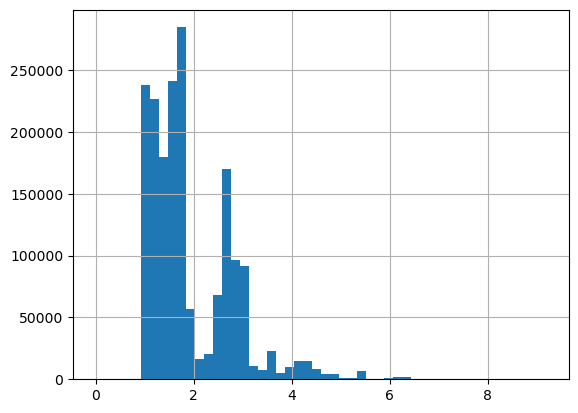

In [13]:
df["Ernedc (g/km)"].hist(bins = 50)

(0.0, 5.0)

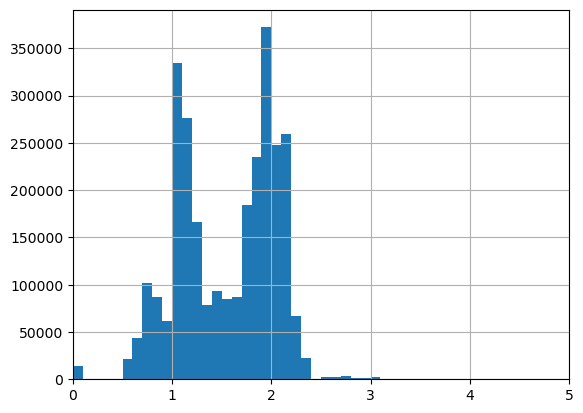

In [14]:
df["Erwltp (g/km)"].hist(bins = 200)
plt.xlim(0,5)

### **clean**

In [3]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh.parquet")

#### Step 1-8: cleanup

In [ ]:
# Processing IT column to extract individual IT Codes

# Step 0: Initialize 'IT_valid' and 'IT_invalid' columns with np.nan
df['IT_valid'] = np.nan
df['IT_invalid'] = df['IT']

# Step 1: Replace Invalid Characters
def replace_invalid_chars(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values that have invalid characters
    matches = original_series.str.contains(r'[^a-zA-Z0-9\+\?]', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace invalid characters with space
    series[matches] = series[matches].str.replace(r'[^a-zA-Z0-9\+\?]', ' ', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 1
df['IT_invalid'], matched_values_invalid_chars, modified_rows_invalid_chars, diff_nunique_invalid_chars = replace_invalid_chars(df['IT_invalid'])
print(f"Modified {modified_rows_invalid_chars} rows by replacing invalid characters.")
print(f"Change in number of unique values: {diff_nunique_invalid_chars}")
print("Values that had invalid characters (original state):")
print(matched_values_invalid_chars)

# Step 2: Strip Leading and Trailing Spaces
def strip_spaces(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with leading or trailing spaces
    matches = original_series.str.contains(r'^\s+|\s+$', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Strip leading and trailing spaces
    series[matches] = series[matches].str.strip()

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 2
df['IT_invalid'], matched_values_strip_spaces, modified_rows_strip_spaces, diff_nunique_strip_spaces = strip_spaces(df['IT_invalid'])
print(f"Modified {modified_rows_strip_spaces} rows by stripping leading and trailing spaces.")
print(f"Change in number of unique values: {diff_nunique_strip_spaces}")
print("Values that had leading or trailing spaces (original state):")
print(matched_values_strip_spaces)

# Step 3: Reduce Multiple Spaces to Single Spaces
def reduce_multiple_spaces(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with multiple spaces
    matches = original_series.str.contains(r'\s{2,}', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace multiple spaces with a single space
    series[matches] = series[matches].str.replace(r'\s{2,}', ' ', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 3
df['IT_invalid'], matched_values_reduce_spaces, modified_rows_reduce_spaces, diff_nunique_reduce_spaces = reduce_multiple_spaces(df['IT_invalid'])
print(f"Modified {modified_rows_reduce_spaces} rows by reducing multiple spaces to single spaces.")
print(f"Change in number of unique values: {diff_nunique_reduce_spaces}")
print("Values that had multiple spaces (original state):")
print(matched_values_reduce_spaces)

# Step 4: Replace 'E' Not Followed by a Letter with 'e'
def replace_E_not_followed_by_letter(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify 'E' not followed by a letter
    matches = original_series.str.contains(r'E(?![a-zA-Z])', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace 'E' not followed by a letter with 'e'
    series[matches] = series[matches].str.replace(r'E(?![a-zA-Z])', 'e', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 4
df['IT_invalid'], matched_values_replace_E, modified_rows_replace_E, diff_nunique_replace_E = replace_E_not_followed_by_letter(df['IT_invalid'])
print(f"Modified {modified_rows_replace_E} rows by replacing 'E' not followed by a letter with 'e'.")
print(f"Change in number of unique values: {diff_nunique_replace_E}")
print("Values that had 'E' not followed by a letter (original state):")
print(matched_values_replace_E)

# Step 5: Replace 'i', 'I', 'l', 'L' Not Followed by a Letter with '1'
def replace_iIlL_not_followed_by_letter(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify 'i', 'I', 'l', 'L' not followed by a letter
    matches = original_series.str.contains(r'[iIlL](?![a-zA-Z])', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace 'i', 'I', 'l', 'L' not followed by a letter with '1'
    series[matches] = series[matches].str.replace(r'[iIlL](?![a-zA-Z])', '1', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 5
df['IT_invalid'], matched_values_replace_iIlL, modified_rows_replace_iIlL, diff_nunique_replace_iIlL = replace_iIlL_not_followed_by_letter(df['IT_invalid'])
print(f"Modified {modified_rows_replace_iIlL} rows by replacing 'i', 'I', 'l', 'L' not followed by a letter with '1'.")
print(f"Change in number of unique values: {diff_nunique_replace_iIlL}")
print("Values that had 'i', 'I', 'l', 'L' not followed by a letter (original state):")
print(matched_values_replace_iIlL)

# Step 6: Eliminate Spaces After 'e'
def eliminate_spaces_after_e(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with spaces after 'e'
    matches = original_series.str.contains(r'e\s+', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Replace one or more spaces after 'e' with 'e'
    series[matches] = series[matches].str.replace(r'e\s+', 'e', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 6
df['IT_invalid'], matched_values_spaces_after_e, modified_rows_spaces_after_e, diff_nunique_spaces_after_e = eliminate_spaces_after_e(df['IT_invalid'])
print(f"Modified {modified_rows_spaces_after_e} rows by eliminating spaces after 'e'.")
print(f"Change in number of unique values: {diff_nunique_spaces_after_e}")
print("Values that had spaces after 'e' (original state):")
print(matched_values_spaces_after_e)

# Step 7: Remove Leading Zeros in Country Codes and Type Codes
def remove_leading_zeros(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values with leading zeros in country codes or type codes
    matches = original_series.str.contains(r'e0\d', regex=True) | original_series.str.contains(r'\s0\d', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Remove leading zeros in country codes: 'e0X' -> 'eX'
    series[matches] = series[matches].str.replace(r'e0(\d)', r'e\1', regex=True)

    # Remove leading zeros in type codes: ' 0Y' -> ' Y'
    series[matches] = series[matches].str.replace(r'\s0(\d)', r' \1', regex=True)

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 7
df['IT_invalid'], matched_values_leading_zeros, modified_rows_leading_zeros, diff_nunique_leading_zeros = remove_leading_zeros(df['IT_invalid'])
print(f"Modified {modified_rows_leading_zeros} rows by removing leading zeros in country and type codes.")
print(f"Change in number of unique values: {diff_nunique_leading_zeros}")
print("Values that had leading zeros in country or type codes (original state):")
print(matched_values_leading_zeros)

# Step 8: Eliminate Trailing Country Codes
def eliminate_trailing_country_codes(series):
    series = series.astype(str)
    original_nunique = series.nunique()
    original_series = series.copy()

    # Identify values that have trailing country codes without type codes
    matches = original_series.str.contains(r'e(?:[1-9]|[1-2][0-9]|3[0-5])\s*$', regex=True)
    matched_values = original_series[matches].unique().tolist()

    # Remove trailing country codes
    series[matches] = series[matches].str.replace(r'e(?:[1-9]|[1-2][0-9]|3[0-5])\s*$', '', regex=True)

    # Strip any trailing spaces resulting from removal
    series[matches] = series[matches].str.rstrip()

    # Convert back to category
    series = series.astype('category')

    # Calculate modifications
    modified_rows = matches.sum()
    diff_nunique = series.nunique() - original_nunique

    return series, matched_values, modified_rows, diff_nunique

# Execute Step 8
df['IT_invalid'], matched_values_trailing_cc, modified_rows_trailing_cc, diff_nunique_trailing_cc = eliminate_trailing_country_codes(df['IT_invalid'])
print(f"Modified {modified_rows_trailing_cc} rows by eliminating trailing country codes.")
print(f"Change in number of unique values: {diff_nunique_trailing_cc}")
print("Values that had trailing country codes (original state):")
print(matched_values_trailing_cc)

Modified 4874700 rows by replacing invalid characters.
Change in number of unique values: -73
Values that had invalid characters (original state):
['e1 8', 'e1 3', 'e1 08', ' ', 'e24 10 e24 3 e24 9', 'e24 9', 'e24 10 e24 9', 'e24 3 e24 9', 'e24 2', 'e24 10 e24 2', 'E24 3. E24 9', 'E24 10. E24 3. E24 9', 'E24 2', 'E24 10. E24 2', 'E24 9', 'E24 10. E24 9', 'e 24 3 e24 9', 'e 24 2', 'e24 3 9', 'e24 10 3 9', 'e24 3 9 10', 'e24 9 10', 'e24 2 10', '715/2007/EC*136/2014/EC  (ZX)', '715/2007/EC*136/2014/EC (ZX)', '715/2007/EC*136/2014/EC (J)', '715/2007/EC*136/2014/EC  (J)', 'e24 3, e24 9', 'e1 10', 'e1 10 8', 'e1 2', 'E24 3, E24 9', 'e24 10, e24 3, ', 'E13 1', 'e13 1', 'E1 8', 'E1 10', 'E1 3', 'e1 8 10', '715/2007/EC*195/2013/EC (J)', 'E24 10', 'E1 2', 'E24 3 9', 'E24 10 9', 'E1 08', 'e24 10', 'e24 3  e24 9', 'e24 10  e24 3  e24 9', 'e24 9  ', 'e24 10 e24 9 ', 'e24 3 e24 9 ', 'e24 2  ', 'e24 10  e24 9', 'e24 10 9', 'e1 13', 'e1 10 3', 'E1 10 8', 'e 24 9', 'e1 0', 'E24 3 9 10', 'e1 3 10', 'e24

In [16]:
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))
all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))

       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid   float64             0              0  14442792      0   
1  IT_invalid  category       9564034              0         0      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  
       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid  category             0              0  14442792      0   
1  IT_invalid  category             0              0   9564034      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  


##### save/read

In [17]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT8.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT8.parquet")
all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

#### Step 9: (f: filter_and_split_valid_tacs(df))

In [19]:
# Execute Step 9
# Filter valid IT codes (Type Approval codes (TAC)) and move them from IT_invalid to IT_valid
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2578512 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 310
List of unique valid TACs transferred to 'IT_valid':
['e1 8', 'e1 3', 'e24 10 e24 3 e24 9', 'e24 9', 'e24 10 e24 9', 'e24 3 e24 9', 'e24 2', 'e24 10 e24 2', 'e1 10', 'e1 2', 'e24 10 e24 3', 'e13 1', 'e24 10', 'e1 13', 'e11 19', 'e1 19', 'e24 9 e24 10', 'e1 9', 'e24 19', 'e8 19', 'e24 19 e24 9', 'e1 18', 'e1 12', 'e24 3', 'e24 1', 'e13 19', 'e6 19', 'e9 19', 'e3 17', 'e3 19', 'e2 4', 'e2 22', 'e6 20', 'e2 17', 'e9 17', 'e5 17', 'e24 17', 'e6 15', 'e2 12', 'e13 22', 'e13 17', 'e2 17 e9 17', 'e17 19', 'e2 19', 'e11 20', 'e1 14', 'e1 17', 'e13 3', 'e4 17', 'e11 17', 'e13 13', 'e8 17', 'e4 19', 'e1 7', 'e4 22', 'e27 19', 'e24 19 e19 9', 'e1 4', 'e13 15', 'e2 24', 'e19 1', 'e1 29', 'e24 3 e24 19', 'e24 3 e24 17', 'e3 22', 'e5 27', 'e13 28', 'e13 27', 'e6 19 e6 28', 'e5 17 e5 29', 'e5 19', 'e6 28', 'e8 25', 'e1 17 e1 28 e1 29', 'e6 15 e6

In [20]:
print(count_missing_values2(df, ['IT_valid', 'IT_invalid']))

       Column Data Type  nan (string)  None (string)    np.nan  pd.NA  \
0    IT_valid  category             0              0  11864280      0   
1  IT_invalid  category             0              0  12142546      0   

   None (object)  Empty string  
0              0             0  
1              0         86458  


##### save/read

In [21]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT9.parquet")

In [2]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT9.parquet")
all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid'])
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,11864280,0,0,0
1,IT_invalid,category,0,0,12142546,0,0,86458


#### Step 10: Expand TACs

In [4]:
# Step 10: Expand TACs with Shared Country Codes
df = expand_shared_country_codes(df)


Modified 2196513 rows by expanding shared country codes.
Change in number of unique values in IT_invalid after expansion: 0
Values that matched the shared country code criteria (original state):
['e24 3 9', 'e24 10 3 9', 'e24 3 9 10', 'e24 9 10', 'e24 2 10', 'e1 10 8', 'e1 8 10', 'e24 10 9', 'e1 10 3', 'e1 3 10'] ...

Sample transformations:
Before: e13 33 37 --> After: e13 33 e13 37
Before: e8 29 37 --> After: e8 29 e8 37
Before: e2 29 37 --> After: e2 29 e2 37
Before: e9 28 29 --> After: e9 28 e9 29
Before: e24 9 10 --> After: e24 9 e24 10


In [5]:
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,11864280,0,0,0
1,IT_invalid,category,0,0,12142546,0,0,86458


In [6]:
# Again filter newly mined valid IT codes (Type Approval codes (TAC)) and move them from IT_invalid to IT_valid
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2196513 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 346
List of unique valid TACs transferred to 'IT_valid':
['e24 3 e24 9', 'e24 10 e24 3 e24 9', 'e24 3 e24 9 e24 10', 'e24 9 e24 10', 'e24 2 e24 10', 'e1 10 e1 8', 'e1 8 e1 10', 'e24 10 e24 9', 'e1 10 e1 3', 'e1 3 e1 10', 'e24 9 e24 19', 'e24 10 e24 2', 'e24 19 e24 9', 'e1 2 e1 10', 'e3 17 e3 19', 'e29 9 e29 19', 'e1 8 e1 13', 'e9 17 e9 19', 'e24 10 e24 17', 'e24 17 e24 19', 'e13 17 e13 19', 'e8 17 e8 19', 'e24 17 e24 19 e24 25', 'e24 3 e24 17', 'e24 3 e24 17 e24 19', 'e24 3 e24 19', 'e2 17 e2 19', 'e24 3 e24 10', 'e24 3 e24 17 e24 19 e24 25', 'e24 17 e24 25', 'e9 27 e9 19', 'e34 3 e34 17', 'e24 3 e24 10 e24 17', 'e24 3 e24 9 e24 19', 'e4 17 e4 19', 'e13 19 e13 22', 'e11 1 e11 19', 'e4 19 e4 22', 'e2 19 e2 22', 'e2 19 e2 17', 'e24 3 e24 17 e24 25', 'e24 17 e24 3', 'e24 19 e24 3', 'e24 17 e24 19 e24 3', 'e12 17 e12 19', 'e24 3 e24 27', 

In [7]:
from IPython.display import display, HTML

# Create a scrollable div for the output
unique_values = df['IT_valid'].cat.categories if df['IT_valid'].dtype.name == 'category' else df['IT_valid'].unique()
html_output = '<div style="max-height: 300px; overflow-y: scroll; border: 1px solid black;">' \
              + '<br>'.join(map(str, unique_values)) + '</div>'

# Display the scrollable output
display(HTML(html_output))

##### save/read

In [8]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT10.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT10.parquet")
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9667767,0,0,0
1,IT_invalid,category,0,0,14339059,0,0,86458


#### Step 11:Expand Multiple Country Codes in TAC Entries

In [ ]:
# Execute Step 11: Expand Multiple Country Codes in ITcode/TAC Entries
df = expand_multiple_country_codes(df)


=== Step 11: Expand Multiple Country Codes ===
Modified 9562 rows by expanding multiple country codes.
Change in number of unique values after expansion: -30
Values that matched the multiple country code criteria (original state):
['e11 19 NEDC e5 28 WLTP', 'e4 17 19 e4 29 28', 'e19 17 19 e19 28 29', 'e24 17 e24 19', 'e5 29+ e5 28', 'e4 17 e4 19', 'e2 19 e2 17', 'e4 29 28 e4 17 19', 'e5 17 e5 29', 'e4 17 e4 29'] ...

Sample transformations:
Before: e2 28e2 29 --> After: e2 28 e2 29
Before: e11 e5 28 --> After: e5 28
Before: e5 e5 29 --> After: e5 29
Before: e2 e2 28 29 --> After: e2 28 e2 29
Before: e4 e4 e4 29 e4 28 --> After: e4 29 e4 28
Before: e4 e4 29 --> After: e4 29
Before: e5 e5 29 --> After: e5 29
Before: e11 NEDC e5 28 WLTP --> After: NEDC e5 28 WLTP
Before: e11 NEDC e5 28 WLTP --> After: NEDC e5 28 WLTP
Before: e11 e5 28 --> After: e5 28
Before: e9 e9 28 29 --> After: e9 28 e9 29
Before: e5 e5 32 e5 37 --> After: e5 32 e5 37
Before: e9 e9 29 --> After: e9 29
Before: e19 e19

In [11]:
# Again filter newly mined valid IT codes (Type Approval codes (TAC)) and move them from IT_invalid to IT_valid
df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 8120 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 72
List of unique valid TACs transferred to 'IT_valid':
['e4 17 e4 19 e4 29 e4 28', 'e19 17 e19 19 e19 28 e19 29', 'e24 17 e24 19', 'e4 17 e4 19', 'e2 19 e2 17', 'e4 29 e4 28 e4 17 e4 19', 'e5 17 e5 29', 'e4 17 e4 29', 'e2 17 e2 19 e2 28 e2 29', 'e9 17 e9 19 e9 28 e9 29', 'e2 28 e2 29', 'e9 17 e9 19 e9 29 e9 28', 'e2 17 e2 29', 'e24 17 e24 3', 'e24 17 e24 19 e24 3', 'e24 17 e24 25 e24 3', 'e24 17 e24 19 e24 25', 'e24 17 e24 25', 'e24 19 e24 3', 'e24 3 e24 19', 'e9 17 e9 29', 'e2 17', 'e2 17 e2 19 e9 28 e9 29', 'e4 19 e4 28', 'e5 29', 'e4 29', 'e4 28', 'e4 29 e4 28', 'e2 29', 'e5 28', 'e9 29', 'e5 29 e5 28', 'e9 29 e9 28', 'e2 33', 'e6 28', 'e9 28 e9 29', 'e3 33', 'e19 28 e19 29', 'e2 28', 'e19 29 e19 37', 'e2 33 e2 37', 'e4 19 e4 29 e4 28', 'e32 37', 'e2 29 e2 28', 'e8 29 e8 28', 'e5 32 e5 37', 'e4 19 e5 29 e5 28', 'e4 28 e4 28', 'e4 37 

In [12]:
count_missing_values2(df,['IT_valid','IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9659647,0,0,0
1,IT_invalid,category,0,0,14347179,0,0,86572


##### save/read

In [13]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT11.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT11.parquet")

#### Step 12 individual mapping of invalid IT codes

In [14]:
from IPython.display import display, HTML

# Create a scrollable div for the output
unique_values = df['IT_invalid'].cat.categories if df['IT_invalid'].dtype.name == 'category' else df['IT_invalid'].unique()
html_output = '<div style="max-height: 300px; overflow-y: scroll; border: 1px solid black;">' \
              + '<br>'.join(map(str, unique_values)) + '</div>'

# Display the scrollable output
display(HTML(html_output))

In [ ]:
# Step 12: map some remaining values of IT_invalid to valid IT Codes/TACs


mappings_IT = [
    # Map 'e e2 28 29'
    (['e e2 28 29'], 'e2 28 29'),
    # Map 'e e5 29'
    (['e e5 29'], 'e5 29'),
    # Map 'e11 19 NED', 'e11 19 NEDC e5 28 WLTP'
    (['e11 19 NED'], 'e11 19'),
    (['e11 19 NEDC e5 28 WLTP'], 'e11 19 e5 28'),
    # Map 'e1117', 'e1119' to 'e11 17', 'e11 19'
    (['e1117'], 'e11 17'),
    (['e1119'], 'e11 19'),
    # Map variations of 'e13 17 19'
    (['e13 17 19 HIGH', 'e13 17 19 High', 'e13 17 19 LOW', 'e13 17 19 Low',
      'e13 17 19 MID', 'e13 17 19 Mid', 'e13 17 19 low', 'e13 17 19 mid',
      'e13 1719', 'e13 1719 Mid', 'e131719'], 'e13 17 19'),
    # Map 'e13 1728 29' to 'e13 17 28 29'
    (['e13 1728 29'], 'e13 17 28 29'),
    # Map 'e13 27 19' variations
    (['e13 27 19 HIGH', 'e13 27 19 Mid'], 'e13 27 19'),
    # Map concatenated 'e13' codes
    (['e1317'], 'e13 17'),
    (['e1319'], 'e13 19'),
    (['e1328'], 'e13 28'),
    (['e132829'], 'e13 28 29'),
    (['e1329'], 'e13 29'),
    (['e1329 37'], 'e13 29 37'),
    (['e1337'], 'e13 37'),
    # Map 'e2' concatenated codes
    (['e2 1719', 'e21719', 'e217 19'], 'e2 17 19'),
    (['e2 28 229', 'e2 2829', 'e228 29', 'e228 29'], 'e2 28 29'),
    (['e2 33 e237', 'e2 3337'], 'e2 33 37'),
    (['e2 2937'], 'e2 29 37'),
    (['e212'], 'e2 12'),
    (['e217'], 'e2 17'),
    (['e219'], 'e2 19'),
    # Map 'e24' codes
    (['e24 1719'], 'e24 17 19'),
    (['e2429'], 'e24 29'),
    # Map 'e4' codes
    (['e4 17 e419'], 'e4 17 e4 19'),
    (['e417'], 'e4 17'),
    (['e4 19 2829', 'e4 19 2928'], 'e4 19 28 29'),
    (['e417 e4 29 e4 28', 'e429 e428 e417'], 'e4 17 e4 28 e4 29'),
    (['e432 37', 'e4 32037'], 'e4 32 37'),
    (['e437'], 'e4 37'),
    # Map 'e5' codes
    (['e5 28 WLTP', 'e5 28WLTP', 'NEDC e5 28 WLTP'], 'e5 28'),
    (['e5 2832'], 'e5 28 32'),
    (['e5 32 e537'], 'e5 32 e5 37'),
    (['e5 37 WLTP e9 32 WLTP', 'e5 37 wltp e9 32 wltp'], 'e5 37 e9 32'),
    (['e5 3732'], 'e5 37 32'),
    (['e517'], 'e5 17'),
    (['e517 e5 29', 'e517 e529'], 'e5 17 e5 29'),
    (['e517 e519 e529 e528'], 'e5 17 e5 19 e5 29 e5 28'),
    (['e529'], 'e5 29'),
    (['e529 e537'], 'e5 29 e5 37'),
    (['e532'], 'e5 32'),
    (['e537'], 'e5 37'),
    (['e59 e5 29'], 'e5 9 e5 29'),
    # Map 'e6' codes
    (['e619'], 'e6 19'),
    (['e619 e6 28', 'e619 e628'], 'e6 19 e6 28'),
    (['e628'], 'e6 28'),
    (['e637', 'e637e'], 'e6 37'),
    # Map 'e8' codes
    (['e8 192829'], 'e8 19 28 29'),
    (['e81719'], 'e8 17 19'),
    (['e819'], 'e8 19'),
    # Map 'e9' codes
    (['e9 1719'], 'e9 17 19'),
    (['e9 2719'], 'e9 27 19'),
    (['e9 29+'], 'e9 29'),
    (['e9 3732'], 'e9 37 32'),
    (['e917'], 'e9 17'),
    (['e917 19', 'e91719'], 'e9 17 19'),
    (['e91719 e92829'], 'e9 17 19 e9 28 29'),
    (['e919'], 'e9 19'),
    (['e929'], 'e9 29'),
    (['e932'], 'e9 32'),
    # new mappings
    (['e1329 37'], 'e13 29 e13 37'),
    (['?3 29'], 'e3 29'),
    (['e4 29 + e4 37'], 'e4 29 e4 37'),
    (['e4 29 +'], 'e4 29'),
    (['e1 0'], 'e1 0'),
    (['e2 0'], 'e2 0'),
    (['e2 3729'], 'e2 37 e2 29'),
    (['e2 43 17 19'], 'e2 43 e2 17 e2 19'),
    (['e229 e228 e217 e219'], 'e2 29 e2 28 e2 17 e2 19'),
    (['e233 e2 37'], 'e2 33 e2 37'),
    (['e3 28 e3 32 e3 37 e3 28 e3 32 e3 37'], 'e3 28 e3 32 e3 37'),
    (['e4 29 2817', 'e4 292817'], 'e4 29 e4 28 e4 17'),
    (['e4 32 + e4 37'], 'e4 32 e4 37'),
    (['e41922', 'e419 22'], 'e4 19 e4 22'),
    (['e41927'], 'e4 19 e4 27'),
    (['e45 29'], 'e4 5 e4 29'),
    (['e46 37'], 'e4 6 e4 37'),
    (['e5 29 e37'], 'e5 29 e5 37'),
    (['e8 919'], 'e8 9 e8 19'),
    (['e9 219 28 29'], 'e9 2e9 19 e9 28 e9 29'),
    (['e9 29037'], 'e9 29 e9 37'),
    (['E1 8 33'], 'e1 8 e1 33'),
    ([''], np.nan)
]

# Apply the renaming to the 'IT_invalid' column
rename_catval(df, "IT_invalid", mappings_IT)

In [16]:
# after mapping filter and go through steps 10 and 11 again to extract newly generated valid IT codes (TACs)

df = filter_and_split_valid_tacs(df)

# Execute Step 10
df = expand_shared_country_codes(df)

df = filter_and_split_valid_tacs(df)

# Execute Step 11:
df = expand_multiple_country_codes(df)

df = filter_and_split_valid_tacs(df)

=== Filter and Split Valid TACs ===
Transferred 2996 rows containing valid TAC entries to 'IT_valid'.
Number of unique TACs transferred to 'IT_valid': 53
List of unique valid TACs transferred to 'IT_valid':
['e5 17', 'e11 17', 'e11 19 e5 28', 'e11 19', 'e2 17', 'e2 19', 'e9 17', 'e4 17', 'e13 19', 'e13 17', 'e8 9 e8 19', 'e6 19', 'e2 12', 'e4 17 e4 19', 'e4 19 e4 22', 'e4 19 e4 27', 'e9 19', 'e8 19', 'e24 29', 'e6 19 e6 28', 'e2 33 e2 37', 'e4 17 e4 28 e4 29', 'e4 29 e4 28 e4 17', 'e2 29 e2 28 e2 17 e2 19', 'e5 9 e5 29', 'e5 28', 'e5 37 e9 32', 'e5 32 e5 37', 'e5 29', 'e5 32', 'e5 37', 'e5 17 e5 29', 'e3 29', 'e6 28', 'e6 37', 'e1 8 e1 33', 'e13 29', 'e13 37', 'e9 32', 'e9 29', 'e4 29 e4 37', 'e4 32 e4 37', 'e5 17 e5 19 e5 29 e5 28', 'e5 29 e5 37', 'e4 29', 'e13 29 e13 37', 'e13 28', 'e2 37 e2 29', 'e3 28 e3 32 e3 37', 'e4 6 e4 37', 'e9 29 e9 37', 'e4 5 e4 29', 'e4 37']

--- Unique Counts Statistics ---
'IT_valid' unique count before processing: 543
'IT_valid' unique count after proces

In [17]:
count_missing_values2(df, ['IT_invalid', 'IT_valid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_invalid,category,0,0,14440472,0,0,0
1,IT_valid,category,0,0,9652926,0,0,0


In [18]:
# Count number of remaining "invalid", i.e. not correctly parsed and extracted values
df.IT_invalid.notna().sum()

2320

##### save/read

In [19]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT12.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT12.parquet")
count_missing_values2(df, ['IT_valid', 'IT_invalid'])

,Column,Data Type,nan (string),None (string),np.nan,pd.NA,None (object),Empty string
0,IT_valid,category,0,0,9652926,0,0,0
1,IT_invalid,category,0,0,14440472,0,0,0


#### Step 13: split IT into 5 columns

In [ ]:
# Split 'IT_valid' column into 5 separate columns for each TAC (up to 5 TACs)
tac_df = split_valid_tacs(df['IT_valid'])

# Concatenate the new columns back to the original DataFrame
df = pd.concat([df, tac_df], axis=1)

# Display the first few rows to verify the result
print(df.head())

       ID Country  VFN    Mp              Mh  \
0  280060      UK  NaN  None         UNKNOWN   
1  280060      UK  NaN  None         AUDI AG   
2  280060      PL  NaN  None      VOLKSWAGEN   
3  280060      HU  NaN  None  HYUNDAI ASSAN    
4  280060      HU  NaN  None            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va                       Ve              Mk  \
0  A-H/MONOCAB     BF11              2A05ASXEGA7        VAUXHALL   
1           B8  LCAKAQ1      QM6B4006R8K927MGEM0            AUDI   
2           1T   CFHCAF  FD6FD62E0187MQS7N1VR0S0      VOLKSWAGEN   
3          ELH    

In [ ]:
# Count unique IT codes across all IT_columns
count_unique_it_codes(df)

Counting unique IT codes across all IT columns...
Identified IT code columns: ['IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']
Total unique IT codes found: 726
Top 10 most common IT codes:
e1 29     1204823
e13 29     625033
e1 2       404091
e24 19     370820
e2 29      355815
e8 29      340792
e13 37     322692
e24 29     313932
e24 17     294846
e8 37      288572
dtype: int64



e1 29            1204823
e13 29            625033
e1 2              404091
e24 19            370820
e2 29             355815
                  ...   
e5 37 e3 32            1
e13 37 e13 37          1
e6 15 e6 14            1
e8 39 e8 37            1
e14 28                 1
Length: 726, dtype: int64

### save/read

In [23]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT_split.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Mp_Mh_IT_split.parquet")
#all_to_nan_and_cat(df, ['IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'])
#print(count_missing_values2(df, ['IT_valid', 'IT_invalid', 'IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']))

In [24]:
df.to_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

In [2]:
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

## **Inspect categories**

In [27]:
# Again, inspect the unique categories in each categorical column after processing
for col in df.select_dtypes(include=['category']):
    num_categories = df[col].nunique(dropna=True)
    print(f"Column '{col}' has {num_categories} unique categorical values.")

Column 'Country' has 30 unique categorical values.
Column 'VFN' has 29048 unique categorical values.
Column 'Mh' has 218 unique categorical values.
Column 'Man' has 477 unique categorical values.
Column 'MMS' has 11561 unique categorical values.
Column 'Tan' has 49909 unique categorical values.
Column 'T' has 26611 unique categorical values.
Column 'Va' has 72533 unique categorical values.
Column 'Ve' has 182640 unique categorical values.
Column 'Mk' has 1745 unique categorical values.
Column 'Cn' has 80814 unique categorical values.
Column 'Ct' has 9 unique categorical values.
Column 'Cr' has 2 unique categorical values.
Column 'Ft' has 11 unique categorical values.
Column 'Fm' has 6 unique categorical values.
Column 'IT' has 1928 unique categorical values.
Column 'Status' has 1 unique categorical values.
Column 'Date of registration' has 1095 unique categorical values.
Column 'ech' has 36 unique categorical values.
Column 'RLFI' has 1544 unique categorical values.
Column 'IT_valid' h

# 1.C Pipeline Part 2 (Step by Step)
All functions can be seen with description in the utils_co2.py function conglomeration
This will be done in the summary of data treatment
- taking the dataframe coming from renaming/mapping categories above
- drop rows without target values
- declare and drop irrelevant columns
- filter df by year (default everything after 2018)
+ Identify electric cars
+ identify electric (or hybrid) cars by looking at electric range and electric capacity
+ making separate column whichs marks the non electric cars
+ fill then all the nan values in electri range and electric capacity with 0 (because they have non, which is equal to 0)
- Outlier handling
- Outlier handling function (IQR factor ab dem als Outlier gewertet wird)
- Zusätzlich in die Funktion: ersetzen durch median oder row delete
+ give to the next steps

## 1.C.0 Import and Load

In [9]:
import numpy as np
import pandas as pd

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

# Load dataframe
# file_path = os.path.abspath(os.path.join('..', 'data', 'EU', 'EU_all_current_shared_Okt_23.parquet')
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet")

In [2]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 14442792 rows, 49 columns

🔍 First 5 rows of the DataFrame:
       ID Country  VFN                Mp              Mh  \
0  280060      UK  NaN               NaN         UNKNOWN   
1  280060      UK  NaN               NaN         AUDI AG   
2  280060      PL  NaN  Volkswagen Group      VOLKSWAGEN   
3  280060      HU  NaN               NaN  HYUNDAI ASSAN    
4  280060      HU  NaN    General Motors            OPEL   

                                Man       MMS                  Tan  \
0                           UNKNOWN  VAUXHALL                  NaN   
1                               NaN      AUDI                  NaN   
2                     VOLKSWAGEN AG       NaN  e1*2001/116*0211*27   
3  HYUNDAI ASSAN OTOMOTIV SANAYI VE   Hyundai  e11*2007/46*0192*04   
4                      ADAM OPEL AG      Opel   e1*2007/46*0374*14   

             T       Va                       Ve              Mk  \
0  A-H/MONOCAB     BF11              2A05A

## 1.C.1 Declare columns to delete

In [11]:
##################################################################################################################################
##############################################    Declare columns to delete    ###################################################
##################################################################################################################################
# Define the dictionary of columns to drop
columns_to_drop_dict = {
    # Global lists of columns to be dropped (default)
    "Car Identifiers":          ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv'],
    "Administrative Values":    ['Date of registration', 'Status', 'Dr', 'Vf', 'De'],
    "Data Related Columns":     ['r', 'R', 'Version_file'],
    "Brand Related":            ['Mp', 'Man', 'MMS'],
    "Temporary or Transformed": ['IT', 'IT_valid', 'IT_invalid', 'Non_Electric_Car'],
    "Target Redundant":         ['Enedc (g/km)', 'Fuel consumption ', 'Erwltp (g/km)', 
                                'Ernedc (g/km)', 'E (g/km)', 'Er (g/km)'],
    "Collinear Attributes":     ['m (kg)'], # At2 will be removed after calculation of "Area (m2)"
    "Other Columns":            ['Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year'],
    # Additional columns to be dropped (individual)
    "Individual Columns":       ['Mk', 'Country', 'Cn', 'VFN']
}


##################################################################################################################################
####################################   Declare columns as gaussian or not for outlier handling   #################################
##################################################################################################################################
# Declare gaussian and non gaussian distributed columns
gaussian_cols = ['m (kg)', 'Mt',  'W (mm)', 'At1 (mm)', 'At2 (mm)']
non_gaussian_cols = [ 'ec (cm3)', 'ep (KW)', 'Ewltp (g/km)']
# lambda values for BoxCox Transformation of non-gaussian columns
lambda_dict = {
    'ec (cm3)': -0.669,
    'ep (KW)':  -0.599,
}
##################################################################################################################################

## 1.C.2 Common Steps of Preprocessing / Feature Engineeering

In [3]:

##################################################################################################################################
################################  Common Steps of Preprocessing / Feature Engineeering ###########################################
##################################################################################################################################
    
# Drop rows where 'Ewltp (g/km)' is NaN
df = drop_rows_without_target(df, target='Ewltp (g/km)')
print("Dropped all rows without the target variable.")

# Make electric car column and replace nans with 0s in electric range&capacity column
df = process_electric_car_data(df, replace_nan=False, make_electric_car_column=True)
# Drop all electric
df = df[df['Non_Electric_Car'] == 'True']
print('Dropped all electric cars.')

# Filter data frame for cars and entries which are younger than 2019
df = filter_dataframe_by_year(df, year=2019)

# Drop everything except top 3 countries
df = df[df['Country'].isin(['DE', 'FR', 'IT'])]
print("Dropped all but top 3 countries (DE, FR, IT).")

# Drop columns as specified
df = drop_irrelevant_columns(df, columns_to_drop_dict)

# Outlier Handling (first run): replace with median for gaussian, drop for non-gaussian numerical attributes
#df = replace_outliers_with_median(df, columns=gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)
#df = iqr_outlier_removal(df, columns=non_gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)

Dropped all rows without the target variable.
Dropped all electric cars.
Dropped all years prior to 2019.
Dropped all but top 3 countries (DE, FR, IT).

====== Dropping/Selecting Columns ======
Columns "Car Identifiers" have been dropped: ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv']
Columns "Administrative Values" have been dropped: ['Date of registration', 'Status', 'Vf', 'De']
Columns "Data Related Columns" have been dropped: ['r']
Columns "Brand Related" have been dropped: ['Mp', 'Man', 'MMS']
Columns "Temporary or Transformed" have been dropped: ['IT', 'IT_valid', 'IT_invalid', 'Non_Electric_Car']
Columns "Target Redundant" have been dropped: ['Enedc (g/km)', 'Fuel consumption ', 'Erwltp (g/km)', 'Ernedc (g/km)']
Columns "Collinear Attributes" have been dropped: ['m (kg)']
Columns "Other Columns" have been dropped: ['Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year']
Columns "Individual Columns" have been dropped: ['Mk', 'Country', 'Cn', 'VFN']
Columns now present in the Data

### save/load

In [ ]:
# Saving file in the repository data folder
#save_data(df, file_name = 'Data_Preprocessed_after_M.parquet')
df.to_parquet("..\\data\\Preprocessed\\intermediate\\Data_Preprocessed_minimal_with_fuel_consumption_with_weights.parquet")

In [ ]:
df = pd.read_parquet("..\\data\\Preprocessed\\intermediate\\Data_Preprocessed_minimal_without_fuel_consumption_with_weights.parquet")

## 1.C.3 Category Selection

### generate category list

In [5]:
generate_category_lists(df, max_categories=20, min_cat_percent=0.1, top_n=20)

# For variable 'Mh', the top 20 categories are displayed based on their value_counts:
# 'VOLKSWAGEN': 789301, 'BMW AG': 723673, 'MERCEDES-BENZ AG': 671403, 'AUDI AG': 579785, 'SKODA': 334917, 'FORD WERKE GMBH': 242485, 'SEAT': 191332, 'RENAULT': 130460, 'PSA': 127805, 'OPEL AUTOMOBILE': 124876, 'AUTOMOBILES PEUGEOT': 93215, 'VOLVO': 86865, 'PORSCHE': 78453, 'JAGUAR LAND ROVER LIMITED': 70811, 'FIAT GROUP': 67796, 'AUTOMOBILES CITROEN': 52733, 'AA-IVA': 33387, 'STELLANTIS EUROPE': 29971, 'TOYOTA': 26112, 'DACIA': 23646
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` wi

### select categories

In [4]:
# For variable 'Mh', the top 20 categories are displayed based on their value_counts:
# 'VOLKSWAGEN': 789301, 'BMW AG': 723673, 'MERCEDES-BENZ AG': 671403, 'AUDI AG': 579785, 'SKODA': 334917, 'FORD WERKE GMBH': 242485, 'SEAT': 191332, 'RENAULT': 130460, 'PSA': 127805, 'OPEL AUTOMOBILE': 124876, 'AUTOMOBILES PEUGEOT': 93215, 'VOLVO': 86865, 'PORSCHE': 78453, 'JAGUAR LAND ROVER LIMITED': 70811, 'FIAT GROUP': 67796, 'AUTOMOBILES CITROEN': 52733, 'AA-IVA': 33387, 'STELLANTIS EUROPE': 29971, 'TOYOTA': 26112, 'DACIA': 23646
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Mh', drop=False, top_n=20, categories_to_keep=['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA'], other_label='Other', min_cat_percent=0.1)

# For variable 'Ct', these are the categories available and their respective value_counts:
# 'M1': 4259289, 'M1G': 417875, 'N1': 533, 'N2': 35, 'N1G': 24, 'N2G': 4, 'N3': 4, 'M2': 0, 'N3G': 0
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['M1', 'M1G', 'N1', 'N2', 'N1G', 'N2G', 'N3', 'M2', 'N3G']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Ct', drop=False, top_n=20, categories_to_keep=['M1', 'M1G', 'N1', 'N2'], other_label='Other', min_cat_percent=0.1)

# For variable 'Ft', these are the categories available and their respective value_counts:
# 'DIESEL': 2320878, 'PETROL': 2293843, 'PETROL/ELECTRIC': 21728, 'NG-BIOMETHANE': 18156, 'LPG': 8898, 'E85': 5873, 'ELECTRIC': 5566, 'DIESEL/ELECTRIC': 5241, 'HYDROGEN': 70, 'BIODIESEL': 0, 'OTHER': 0
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['DIESEL', 'PETROL', 'PETROL/ELECTRIC', 'NG-BIOMETHANE', 'LPG', 'E85', 'ELECTRIC', 'DIESEL/ELECTRIC', 'HYDROGEN', 'BIODIESEL', 'OTHER']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Ft', drop=True, top_n=20, categories_to_keep=['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85', 'BIODIESEL', 'OTHER'], other_label='Other', min_cat_percent=0.1)

# For variable 'Fm', these are the categories available and their respective value_counts:
# 'M': 3881690, 'H': 755160, 'P': 26970, 'B': 9835, 'E': 5566, 'F': 1033
# Please choose which categories to include or adjust the 'top_n' and 'min_cat_percent' parameters.
# ['M', 'H', 'P', 'B', 'E', 'F']
# Note: If both `top_n` and `categories_to_keep` are provided, `categories_to_keep` will be ignored.
# If drop = True, rows will be dropped; otherwise, they will be labeled as 'Other'.
df = filter_categories(df, 'Fm', drop=False, top_n=20, categories_to_keep=['M', 'H', 'P', 'B', 'E', 'F'], other_label='Other', min_cat_percent=0.1)

# Handling IT columns: ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5']
# Aggregating IT codes across IT_1 to IT_5 and listing the top categories:
# 'e1 29': 450239, 'e13 29': 292380, 'e13 37': 181449, 'e24 29': 175265, 'e24 17': 168087, 'e24 19': 163279, 'e2 29': 145153, 'e8 29': 144732, 'e24 28': 130765, 'e9 29': 125027, 'e1 2': 118521, 'e8 37': 102146, 'e13 19': 99698, 'e24 3': 97498, 'e24 37': 95575, 'e13 28': 91373, 'e2 17': 90679, 'e13 17': 85774, 'e9 37': 77894, 'e8 19': 74383
# Please choose the number of top ITs to retain and adjust the 'top_n' and 'min_cat_percent' parameters in the function call.
# Current top 20 ITs:
# ['e1 29', 'e13 29', 'e13 37', 'e24 29', 'e24 17', 'e24 19', 'e2 29', 'e8 29', 'e24 28', 'e9 29', 'e1 2', 'e8 37', 'e13 19', 'e24 3', 'e24 37', 'e13 28', 'e2 17', 'e13 17', 'e9 37', 'e8 19']
df = retain_top_n_ITs(df, top_n=20, IT_columns=['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], other_label='Other', min_cat_percent=0.1)

Categories to keep after applying thresholds: ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA', 'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP', 'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA']
Replaced 201220 values in 'Mh' with 'Other' where not in specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['M1', 'M1G']
Replaced 600 values in 'Ct' with 'Other' where not in specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85']
Dropped 32605 rows where 'Ft' is not in the specified categories or occur less than 0.1% of total rows.
Categories to keep after applying thresholds: ['M', 'H', 'B']
Replaced 1034 values in 'Fm' with 'Other' where not in specified categories or occur less than 0.1% of total ro

## 1.C.4 NaN Handling

### explore

In [6]:
count_missing_values(df)

,Dtype,Missing Count,Percent Missing
Mh,category,13,0.00%
Ct,category,2495,0.05%
m (kg),float32,23,0.00%
Mt,float32,79117,1.69%
Ewltp (g/km),float32,0,0.00%
W (mm),float32,753911,16.11%
At1 (mm),float32,880244,18.81%
At2 (mm),float32,881190,18.83%
Ft,category,6,0.00%
Fm,category,5,0.00%


### generate nan-handling dictionary

In [5]:
nan_handling_strategy = generate_strategy_dict_code(df, default_strategy='drop', special_columns=None)
print(nan_handling_strategy)

nan_handling_strategy = {
    'Mh': 'drop',
    'Ct': 'drop',
    'Mt': 'drop',
    'Ewltp (g/km)': 'drop',
    'W (mm)': 'drop',
    'At1 (mm)': 'drop',
    'Ft': 'drop',
    'Fm': 'drop',
    'ec (cm3)': 'drop',
    'ep (KW)': 'drop',
    'Fuel consumption ': 'drop',
    '#identical occurences': 'drop',
    'IT_1': 'leave_as_nan',
    'IT_2': 'leave_as_nan',
    'IT_3': 'leave_as_nan',
    'IT_4': 'leave_as_nan',
    'IT_5': 'leave_as_nan',
    'Area (m2)': 'drop',
}


### choose nan-nandling for each column

In [5]:
# Possible strategies can be 'drop', 'mean', 'median', 'mode', 'zero', or 'leave_as_nan'

nan_handling_strategy = {
    'Mh': 'drop',
    'Ct': 'drop',
    'Mt': 'drop',
    'Ewltp (g/km)': 'drop',
    'W (mm)': 'drop',
    'At1 (mm)': 'drop',
    'Ft': 'drop',
    'Fm': 'drop',
    'ec (cm3)': 'drop',
    'ep (KW)': 'drop',
    'Fuel consumption ': 'drop',
    '#identical occurences': 'drop',
    'IT_1': 'leave_as_nan',
    'IT_2': 'leave_as_nan',
    'IT_3': 'leave_as_nan',
    'IT_4': 'leave_as_nan',
    'IT_5': 'leave_as_nan',
    'Area (m2)': 'drop',
}


### handle NaNs (execute)

In [6]:
# NaN handling
df = handle_nans(df, nan_handling_strategy)


=========  Handle NaNs  ==============
Column 'Mh': Dropped 13 row(s) containing NaN(s).
Column 'Ct': Dropped 2095 row(s) containing NaN(s).
Column 'Mt': Dropped 73445 row(s) containing NaN(s).
Column 'Ewltp (g/km)': Dropped 0 row(s) containing NaN(s).
Column 'W (mm)': Dropped 742057 row(s) containing NaN(s).
Column 'At1 (mm)': Dropped 868279 row(s) containing NaN(s).
Column 'Ft': Dropped 6 row(s) containing NaN(s).
Column 'Fm': Dropped 5 row(s) containing NaN(s).
Column 'ec (cm3)': Dropped 28 row(s) containing NaN(s).
Column 'ep (KW)': Dropped 5 row(s) containing NaN(s).
Column '#identical occurences': Dropped 0 row(s) containing NaN(s).

Column 'IT_1': Left 1675280 NaN(s) as is.
Column 'IT_2': Left 2836625 NaN(s) as is.
Column 'IT_3': Left 3652029 NaN(s) as is.
Column 'IT_4': Left 3697088 NaN(s) as is.
Column 'IT_5': Left 3730558 NaN(s) as is.



### (optional) separate treatment of Erwltp and Ernedc (only if in df)

In [ ]:
#df = handle_nans_IT_related_columns(df, ['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'], target_columns = ['Erwltp (g/km)', 'Ernedc (g/km)'] , strategy='mean')

## Calculate optimal Lambda for BoxCox

In [7]:
lambda_opt_ep = optimal_boxcox_lambda_weighted(
    series=df['ep (KW)'],
    frequency=df['#identical occurences'],
    coarse=True
)

After filtering, values < 1 in series: 0
Expanded series statistics after filtering:
count    1.902950e+07
mean     1.019254e+02
std      4.983161e+01
min      4.400000e+01
25%      7.300000e+01
50%      9.200000e+01
75%      1.100000e+02
max      1.177000e+03
Name: ep (KW), dtype: float64
Values < 1 in expanded series after filtering: 0


In [8]:
lambda_opt_ep

-0.5993114627478149

In [9]:
lambda_opt_ec = optimal_boxcox_lambda_weighted(
    series=df['ec (cm3)'],
    frequency=df['#identical occurences'],
    coarse=True
)

After filtering, values < 1 in series: 0
Expanded series statistics after filtering:
count    1.902950e+07
mean     1.535223e+03
std      5.179662e+02
min      6.580000e+02
25%      1.199000e+03
50%      1.498000e+03
75%      1.968000e+03
max      7.993000e+03
Name: ec (cm3), dtype: float64
Values < 1 in expanded series after filtering: 0


In [10]:
lambda_opt_ec

-0.6695044159470497

In [ ]:
# Apply BoxCox Transfromation for ec and ep
df = apply_boxcox_transformation_df(df, lambda_dict)

## 1.C.5 Encode categorical columns

### explore

In [ ]:
# count unique IT values
count_unique_it_codes(df)

### encode (execute)

In [ ]:
# Encoding categorical attributes
df = encode_categorical_columns(df, exclude_prefix='IT_', drop_first=True)
df = encode_top_its(df, n=0)  # Encode all present IT values

## 1.C.6 Save Dataframe

In [ ]:
# Saving file in the repository data folder
#save_data(df, file_name = 'Data_Preprocessed_finished.parquet')
df.to_parquet(os.path.join('..', 'data', 'Preprocessing', 'minimal_withoutfc_dupesdropped_frequencies_area_outliers3.0_tn20_mcp00.10.parquet'))

# 1.D Pipeline Part 2 (All in One and batch processig)

## 1.D.0 Import and Load

In [1]:
import numpy as np
import pandas as pd

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

# Load dataframe from file
df = pd.read_parquet("..\\data\\EU\\EU_all_current_shared_Okt_23.parquet") 

In [3]:
df.dtypes

ID                          Int64
Country                  category
VFN                      category
Mp                       category
Mh                       category
Man                      category
MMS                      category
Tan                      category
T                        category
Va                       category
Ve                       category
Mk                       category
Cn                       category
Ct                       category
Cr                       category
r                         float32
m (kg)                    float32
Mt                        float32
Enedc (g/km)              float32
Ewltp (g/km)              float32
W (mm)                    float32
At1 (mm)                  float32
At2 (mm)                  float32
Ft                       category
Fm                       category
ec (cm3)                  float32
ep (KW)                   float32
z (Wh/km)                 float32
IT                       category
Ernedc (g/km) 

## 1.D.1 Specify Parameters and define batch processing function 

In [ ]:
##################################################################################################################################
##############################################    Declare columns to delete    ###################################################
##################################################################################################################################
# Define the dictionary of columns to drop
columns_to_drop_dict = {
    # Global lists of columns to be dropped (default)
    "Car Identifiers":          ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv'],
    "Administrative Values":    ['Date of registration', 'Status', 'Dr', 'Vf', 'De'],
    "Data Related Columns":     ['r', 'R', 'Version_file'],
    "Brand Related":            ['Mp', 'Man', 'MMS'],
    "Temporary or Transformed": ['IT', 'IT_valid', 'IT_invalid', 'Non_Electric_Car'],
    "Target Redundant":         ['Enedc (g/km)', 'Fuel consumption ', 'Erwltp (g/km)', 
                                'Ernedc (g/km)', 'E (g/km)', 'Er (g/km)'],
    "Collinear Attributes":     ['m (kg)'], # At2 will be removed after calculation of "Area (m2)"
    "Other Columns":            ['Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year'],
    # Additional columns to be dropped (individual)
    "Individual Columns":       ['Mk', 'Country', 'Cn', 'VFN']
}


##################################################################################################################################
####################################   Declare columns as gaussian or not for outlier handling   #################################
##################################################################################################################################
# Declare gaussian and non gaussian distributed columns
gaussian_cols = ['m (kg)', 'Mt',  'W (mm)', 'At1 (mm)', 'At2 (mm)']
non_gaussian_cols = [ 'ec (cm3)', 'ep (KW)', 'Ewltp (g/km)']
# lambda values for BoxCox Transformation of non-gaussian columns
lambda_dict = {
    'ec (cm3)': -0.669,
    'ep (KW)':  -0.599,
}
##################################################################################################################################



##################################################################################################################################
#######################   Specify Categories to keep (if not superseded by other filter parameters)  #############################
##################################################################################################################################
# Declare categories to keep (if not superseded by top_n parameter or not meeting percentage threshold (min_cat_percent)
categories_to_keep_dict = {
    "Mh":   ['VOLKSWAGEN', 'BMW AG', 'MERCEDES-BENZ AG', 'AUDI AG', 'SKODA', 'FORD WERKE GMBH', 'SEAT', 'RENAULT', 'PSA',
             'OPEL AUTOMOBILE', 'AUTOMOBILES PEUGEOT', 'VOLVO', 'PORSCHE', 'JAGUAR LAND ROVER LIMITED', 'FIAT GROUP',
             'AUTOMOBILES CITROEN', 'AA-IVA', 'STELLANTIS EUROPE', 'TOYOTA', 'DACIA'],
    "Ct":   ['M1', 'M1G', 'N1', 'N2'],
    "Ft":   ['DIESEL', 'PETROL', 'NG-BIOMETHANE', 'LPG', 'E85', 'HYDROGEN', 'BIODIESEL', 'OTHER'],
    "Fm":   ['M', 'H', 'P', 'B', 'E', 'F'],
}
##################################################################################################################################



##################################################################################################################################
###########################################   Declare NaN Handling Strategies   ##################################################
##################################################################################################################################  
# Possible strategies can be 'drop', 'mean', 'median', 'mode', 'zero', or 'leave_as_nan'
nan_handling_strategy = {
    'Mh':           'drop',
    'Ct':           'drop',
    'Mt':           'drop',
    'Ewltp (g/km)': 'drop',
    'W (mm)':       'drop',
    'At1 (mm)':     'drop',
    'At2 (mm)':     'drop',
    'Ft':           'drop',
    'Fm':           'drop',
    'ec (cm3)':     'drop',
    'ep (KW)':      'drop',
    'IT_1':         'leave_as_nan',
    'IT_2':         'leave_as_nan',
    'IT_3':         'leave_as_nan',
    'IT_4':         'leave_as_nan',
    'IT_5':         'leave_as_nan',
}
##################################################################################################################################



##################################################################################################################################
#####################  Define function to batch process the rest of the preprocessing with variations ############################
##################################################################################################################################

def process_datasets(df,
                     prefix_processed_filename = 'preprocessed_dataset',
                     top_n_list=[5, 10, 15, 20],
                     min_cat_percent_list=[0.1, 1, 5, 10],
                     IQR_outlier_multiplier = 1.5,
                     drop_first_category_at_encoding=True,
                     drop_dupes=True,
                     preserve_weights=True,
                     gaussian_cols = None,
                     non_gaussian_cols = None,
                     categories_to_keep = None,
                     nan_handling_strategy = None):
    
    # initialize filename_list
    filename_list = []
    
    # "save" copy of intermediate dataframe
    df_intermediate = df.copy()
    
    ############# Process all combinations of top_n_list and min_cat_percent ###############
    ########################################################################################
    for top_n in top_n_list:
        for min_cat_percent in min_cat_percent_list:
            
            df = df_intermediate.copy()
                        
            # Create a filename that reflects the parameters
            filename = f"{prefix_processed_filename}_tn{top_n:02d}_mcp{min_cat_percent:05.2f}.parquet"
            filename_list.append(filename)
            
            print("\n=========================================================")
            print(f"====== Processing file {filename} ======")
            print("===========================================================")
            
            # Apply the transformations with current top_n and min_cat_percent
            
            # Filter categories and drop or label "other" according to specified parameters (top_n, min_cat_percent) and/or categories_to_keep
            df = filter_categories(df, 'Mh', drop=False, top_n=top_n, categories_to_keep=categories_to_keep['Mh'],    other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Ct', drop=False, top_n=top_n, categories_to_keep=categories_to_keep['Ct'],     other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Ft', drop=True,  top_n=top_n, categories_to_keep=categories_to_keep['Ft'],     other_label='Other', min_cat_percent=min_cat_percent)
            df = filter_categories(df, 'Fm', drop=False, top_n=top_n, categories_to_keep=categories_to_keep['Fm'],     other_label='Other', min_cat_percent=min_cat_percent)
            df = retain_top_n_ITs (df,                   top_n=top_n, IT_columns=['IT_1', 'IT_2', 'IT_3', 'IT_4', 'IT_5'],  other_label='Other', min_cat_percent=min_cat_percent)
            
            # NaN handling
            df = handle_nans(df, nan_handling_strategy)
            
            # Encoding categorical attributes
            df = encode_categorical_columns(df, exclude_prefix='IT_', drop_first=drop_first_category_at_encoding)
            df = encode_top_its(df, n=0)  # Encode all present IT values
            
            # Drop duplicates
            df = drop_duplicates(df, drop=drop_dupes, subset=None, preserve_weights=preserve_weights)
            
            # Outlier Handling (second run: because of row removal outlier calculation may have changed). no outlier handling on 'Area (m2)'
            #df = replace_outliers_with_median(df, columns=gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)
            #df = iqr_outlier_removal(df, columns=non_gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)
            df = replace_outliers_with_median_weighted(df, columns=gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True, 
                        use_weighted_quartiles=True, weight_column='frequency')
            df = iqr_outlier_removal_weighted(df, columns=non_gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True, 
                        use_weighted_quartiles=True, weight_column='frequency')
            
            # Calculate new attribute 'Area (m2)' and remove 'W (mm)' and 'At2 (mm)'
            df['Area (m2)'] = (df['W (mm)'] * ((df['At1 (mm)'] + df['At2 (mm)'])/2)) / 1000000
            df = df.drop(['At2 (mm)', 'W (mm)'], axis=1)
            print("Calculated attribute 'Area (m2)' as W * (At1+At2)/2).")
            print("Removed column 'At2 (mm)' (collinearity with At1 and Area)")
            
            print("=======================\n")
            
            # Save the DataFrame
            df.to_parquet(os.path.join('..', 'data', 'Preprocessed', filename))
               
    # return list of newly saved dataset files        
    return df, filename_list


## 1.D.2 Execute batch processing


In [3]:
##################################################################################################################################
################################  Common Steps of Preprocessing / Feature Engineeering ###########################################
##################################################################################################################################
    
# Drop rows where 'Ewltp (g/km)' is NaN
df = drop_rows_without_target(df, target='Ewltp (g/km)')
print("Dropped all rows without the target variable.")

# Make electric car column and replace nans with 0s in electric range&capacity column
df = process_electric_car_data(df, replace_nan=False, make_electric_car_column=True)
# Drop all electric
df = df[df['Non_Electric_Car'] == 'True']
print('Dropped all electric cars.')

# Filter data frame for cars and entries which are younger than 2019
df = filter_dataframe_by_year(df, year=2019)

# Drop everything except top 3 countries
df = df[df['Country'].isin(['DE', 'FR', 'IT'])]
print("Dropped all but top 3 countries (DE, FR, IT).")

# Drop columns as specified
df = drop_irrelevant_columns(df, columns_to_drop_dict)

# Apply BoxCox Transfromation for non-gaussian columns (ec and ep)
df = apply_boxcox_transformation_df(df, lambda_dict)

# Outlier Handling (first run): replace with median for gaussian, drop for non-gaussian numerical attributes
#df = replace_outliers_with_median(df, columns=gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)
#df = iqr_outlier_removal(df, columns=non_gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True)
df = replace_outliers_with_median_weighted(df, columns=gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True, 
                        use_weighted_quartiles=True, weight_column='#identical occurences')
df = iqr_outlier_removal_weighted(df, columns=non_gaussian_cols, IQR_distance_multiplier=3.0, apply_outlier_removal=True, 
                        use_weighted_quartiles=True, weight_column='#identical occurences')
            

##################################################################################################################################
#####################  Batch process the rest of the Preprocessing with various parameter combinations ###########################
##################################################################################################################################
        
df, filename_list = process_datasets(df = df,
                                 prefix_processed_filename = 'minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_NoW',
                                 top_n_list=[20],
                                 min_cat_percent_list=[0.1],
                                 IQR_outlier_multiplier = 3.0,
                                 drop_first_category_at_encoding=True,
                                 drop_dupes=True,
                                 preserve_weights=True,
                                 gaussian_cols = gaussian_cols,
                                 non_gaussian_cols = non_gaussian_cols,
                                 categories_to_keep = categories_to_keep_dict,
                                 nan_handling_strategy = nan_handling_strategy
                                 )

# edit file_mapping.csv (append new dataset)
create_or_append_file_mapping(filename_list)

Dropped all rows without the target variable.
Dropped all electric cars.
Dropped all years prior to 2019.
Dropped all but top 3 countries (DE, FR, IT).

====== Dropping/Selecting Columns ======
Columns "Car Identifiers" have been dropped: ['Ve', 'Va', 'T', 'Tan', 'ID', 'tvv']
Columns "Administrative Values" have been dropped: ['Date of registration', 'Status', 'Vf', 'De']
Columns "Data Related Columns" have been dropped: ['r']
Columns "Brand Related" have been dropped: ['Mp', 'Man', 'MMS']
Columns "Temporary or Transformed" have been dropped: ['IT', 'IT_valid', 'IT_invalid', 'Non_Electric_Car']
Columns "Target Redundant" have been dropped: ['Enedc (g/km)', 'Fuel consumption ', 'Erwltp (g/km)', 'Ernedc (g/km)']
Columns "Collinear Attributes" have been dropped: ['m (kg)']
Columns "Other Columns" have been dropped: ['Cr', 'ech', 'RLFI', 'Electric range (km)', 'z (Wh/km)', 'year']
Columns "Individual Columns" have been dropped: ['Mk', 'Country', 'Cn', 'VFN']
Columns now present in the Data

# 1.E Explore/inspect specific datasets

## Import

In [1]:
import numpy as np
import pandas as pd

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

from utils_CO2 import *

# set option so that e.g. df.head() will show all columns and none are omitted
pd.set_option('display.max_columns', None)

## Choose Dataset

In [4]:
# 1.Load and view file mapping

file_mapping_df = load_file_mapping()
display(file_mapping_df.style.set_properties(**{'max-width': '100%'}))


,number,filename
0,1,minimal_with_fuel_consumption_tn05_mcp00.10.parquet
1,2,minimal_with_fuel_consumption_tn05_mcp01.00.parquet
2,3,minimal_with_fuel_consumption_tn05_mcp05.00.parquet
3,4,minimal_with_fuel_consumption_tn05_mcp10.00.parquet
4,5,minimal_with_fuel_consumption_tn10_mcp00.10.parquet
5,6,minimal_with_fuel_consumption_tn10_mcp01.00.parquet
6,7,minimal_with_fuel_consumption_tn10_mcp05.00.parquet
7,8,minimal_with_fuel_consumption_tn10_mcp10.00.parquet
8,9,minimal_with_fuel_consumption_tn15_mcp00.10.parquet
9,10,minimal_with_fuel_consumption_tn15_mcp01.00.parquet


In [ ]:
# 2. Choose Dataset by number
df = load_data_by_number(69)

## Explore

In [3]:
inspect_data(df)

🚀 Basic Data Overview
🗂 Shape of the DataFrame: 2027792 rows, 57 columns

🔍 First 5 rows of the DataFrame:
       Mt  Ewltp (g/km)  W (mm)  At1 (mm)  ec (cm3)  ep (KW)  Mh_AUDI AG  \
0  1412.0         145.0  2590.0    1538.0     999.0     85.0           0   
1  1297.0         128.0  2550.0    1511.0     999.0     70.0           1   
2  1145.0         140.0  2300.0    1413.0    1242.0     51.0           0   
3  1326.0         139.0  2551.0    1499.0     999.0     70.0           0   
4  2421.0         209.0  3200.0    1666.0    2143.0    100.0           0   

   Mh_AUTOMOBILES CITROEN  Mh_AUTOMOBILES PEUGEOT  Mh_BMW AG  Mh_DACIA  \
0                       0                       0          0         0   
1                       0                       0          0         0   
2                       0                       0          0         0   
3                       0                       0          0         0   
4                       0                       0          0      

In [4]:
df.dtypes

Mt                              float32
Ewltp (g/km)                    float32
W (mm)                          float32
At1 (mm)                        float32
ec (cm3)                        float32
ep (KW)                         float32
Mh_AUDI AG                        uint8
Mh_AUTOMOBILES CITROEN            uint8
Mh_AUTOMOBILES PEUGEOT            uint8
Mh_BMW AG                         uint8
Mh_DACIA                          uint8
Mh_FIAT GROUP                     uint8
Mh_FORD WERKE GMBH                uint8
Mh_JAGUAR LAND ROVER LIMITED      uint8
Mh_MERCEDES-BENZ AG               uint8
Mh_OPEL AUTOMOBILE                uint8
Mh_PORSCHE                        uint8
Mh_PSA                            uint8
Mh_RENAULT                        uint8
Mh_SEAT                           uint8
Mh_SKODA                          uint8
Mh_TOYOTA                         uint8
Mh_VOLKSWAGEN                     uint8
Mh_VOLVO                          uint8
Mh_Other                          uint8


### ec and ep

Loaded parquet file from local path.
Loaded file: 'minimal_withoutfc_dupesdropped_frequencies_area_outliers3.0_tn20_mcp00.10.parquet'


<Axes: xlabel='ec (cm3)', ylabel='Count'>

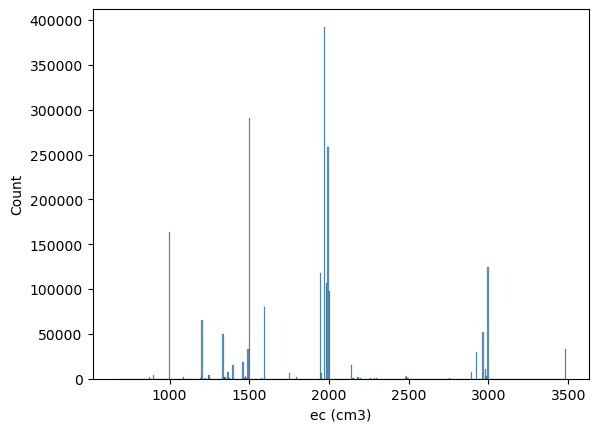

In [13]:
df = load_data_by_number(68)
sns.histplot(data = df, x='ec (cm3)')

Loaded parquet file from local path.
Loaded file: 'minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_tn20_mcp00.10.parquet'


<Axes: xlabel='ec (cm3)', ylabel='Count'>

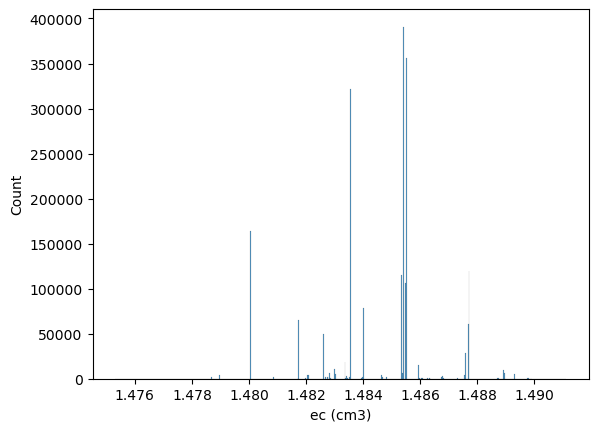

In [10]:
df = load_data_by_number(69)
sns.histplot(data = df, x='ec (cm3)')

In [4]:
weighted_skewness(df['ec (cm3)'], frequency=df['frequency'])

0.038873990626260096

In [5]:
weighted_skewness(df['ep (KW)'], frequency=df['frequency'])

0.001859792512795551

In [23]:
analyze_extreme_values_with_frequency(df, column='ec (cm3)', lambda_value=-0.669, frequency_column='frequency', iqr_multiplier=1.5)

Extreme values for column 'ec (cm3)' (before BoxCox):
1.475307    21
1.491088     1
1.491107    32
Name: ec (cm3), dtype: int64

Weighted IQR bounds for original data: [1.4762277603149414, 1.4909305572509766]
Number of extreme values before BoxCox: 54

Extreme values for column 'boxcox_ec (cm3)' (after BoxCox):
0.342399    21
0.350573     1
0.350583    32
dtype: int64

Weighted IQR bounds for transformed data: [0.34289510548114777, 0.3505067378282547]
Number of extreme values after BoxCox: 54


### Boxplots

Columns to be plotted: ['Mt', 'Ewltp (g/km)', 'W (mm)', 'At1 (mm)', 'ec (cm3)', 'ep (KW)', 'Area (m2)']

Plotting boxplot for column 'Mt'


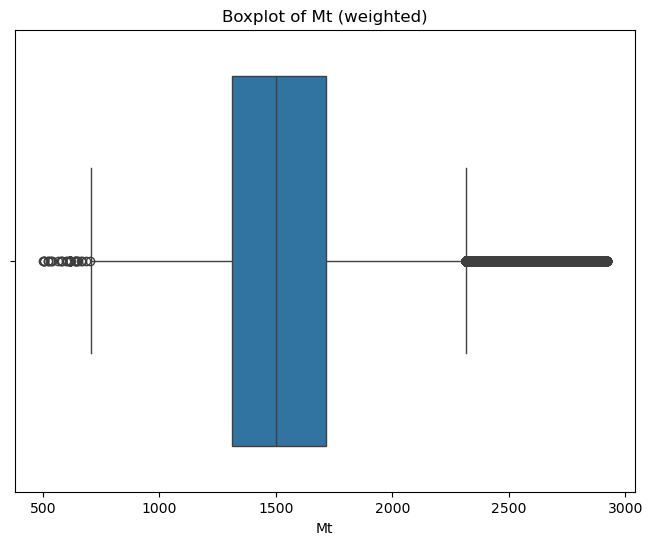


Plotting boxplot for column 'Ewltp (g/km)'


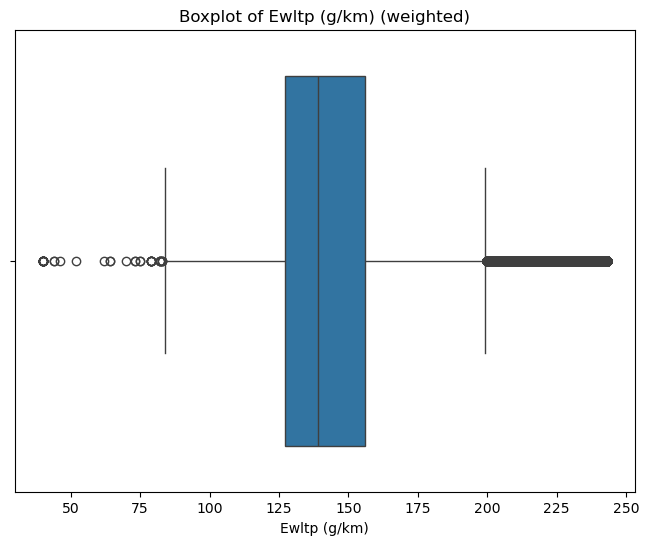


Plotting boxplot for column 'W (mm)'


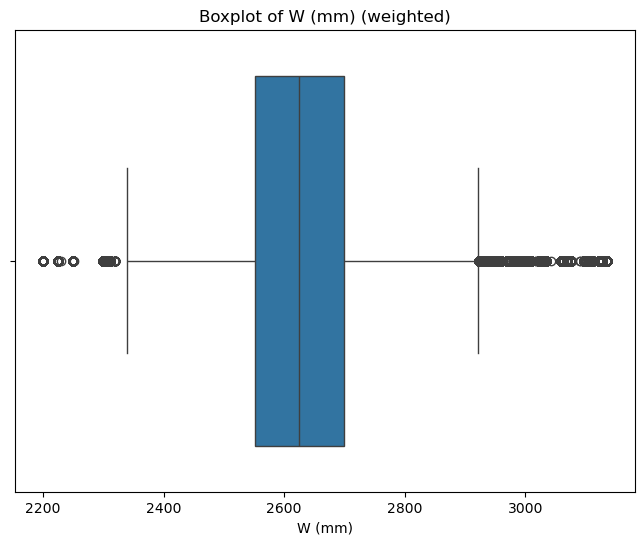


Plotting boxplot for column 'At1 (mm)'


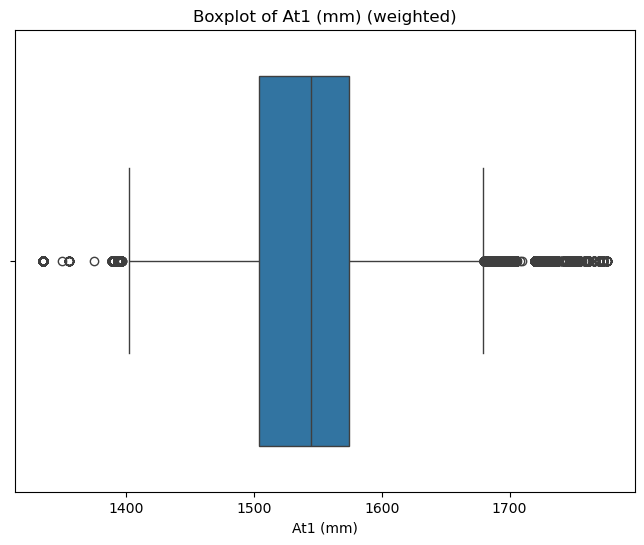


Plotting boxplot for column 'ec (cm3)'


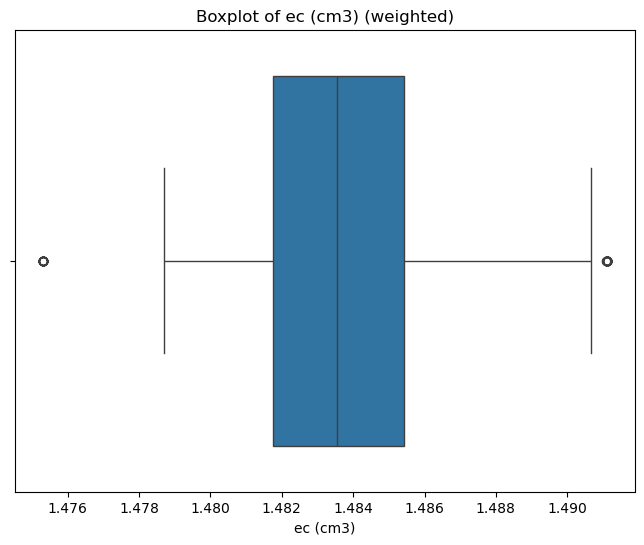


Plotting boxplot for column 'ep (KW)'


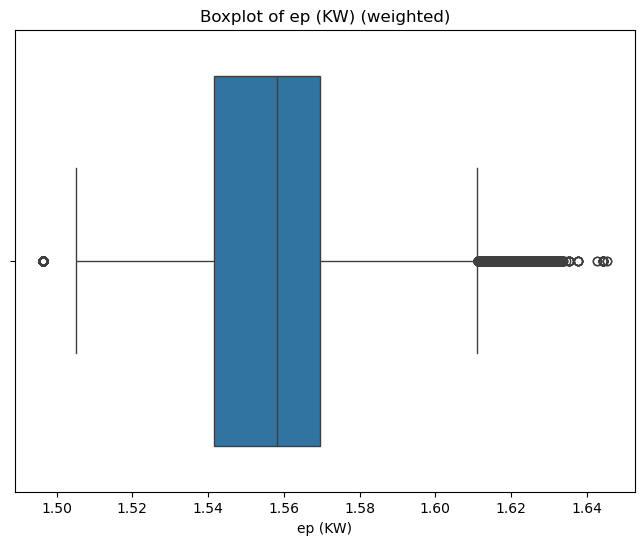


Plotting boxplot for column 'Area (m2)'


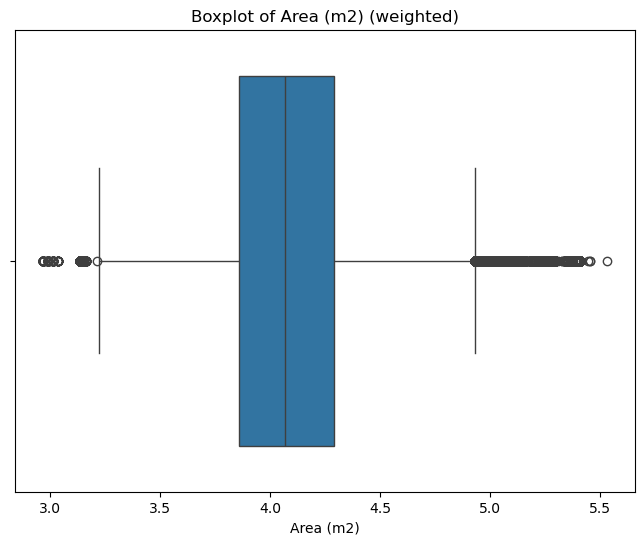

In [6]:
plot_weighted_boxplots(df=df, weight_column='frequency', exclude_columns=None, IQR_distance_multiplier=1.5)

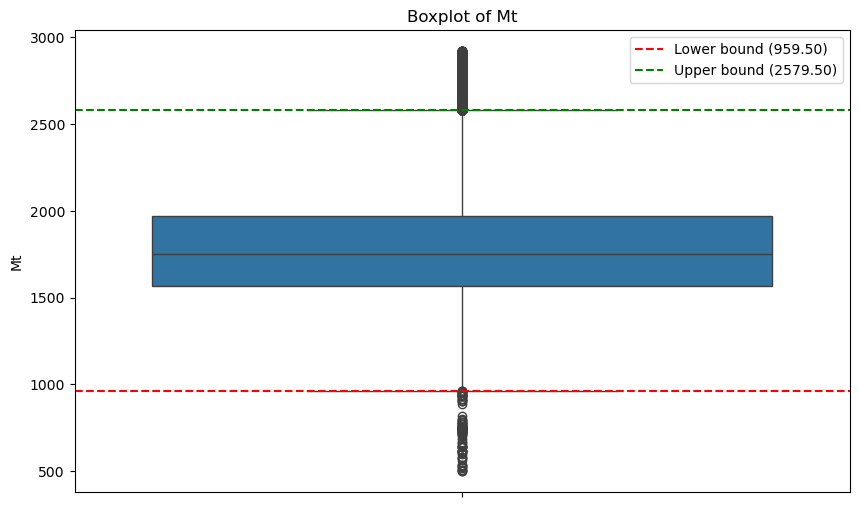

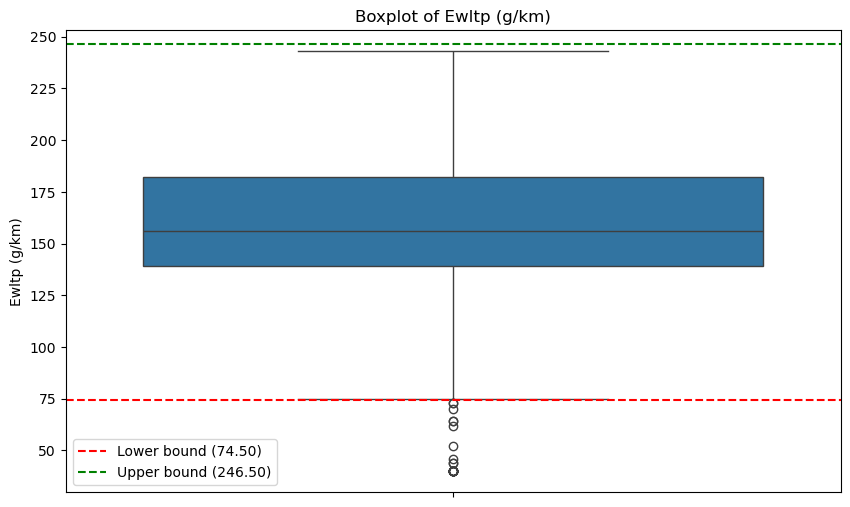

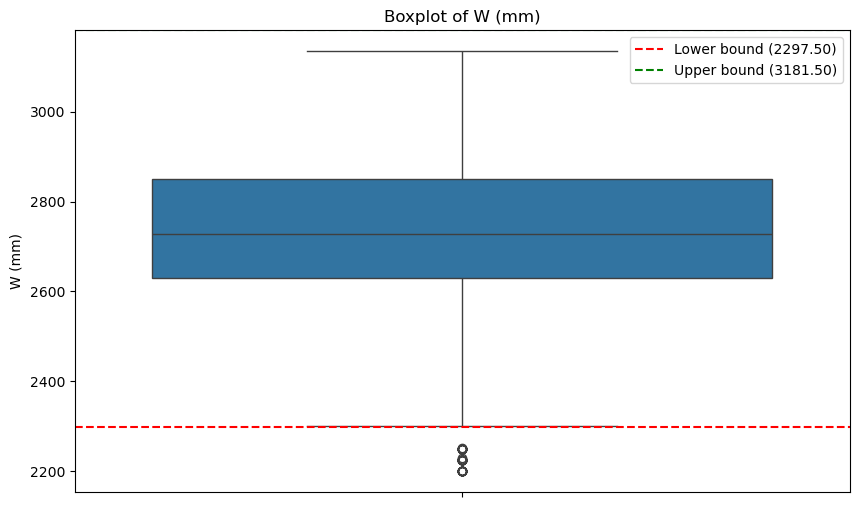

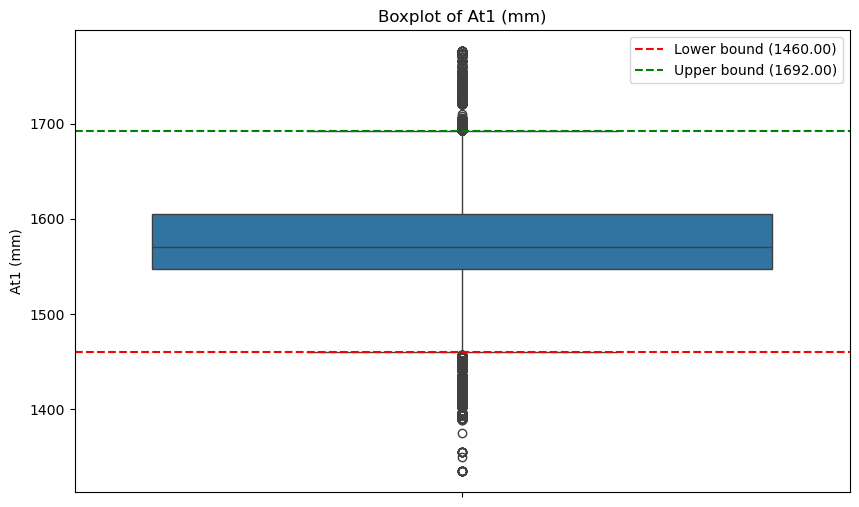

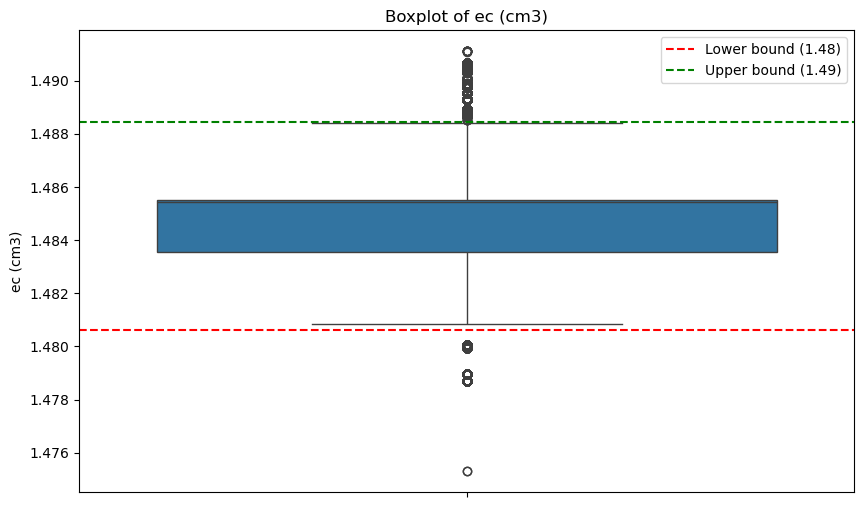

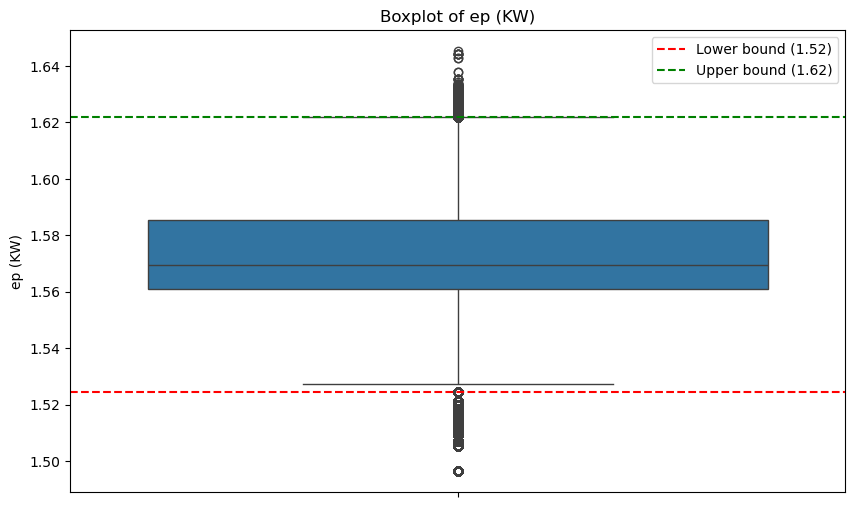

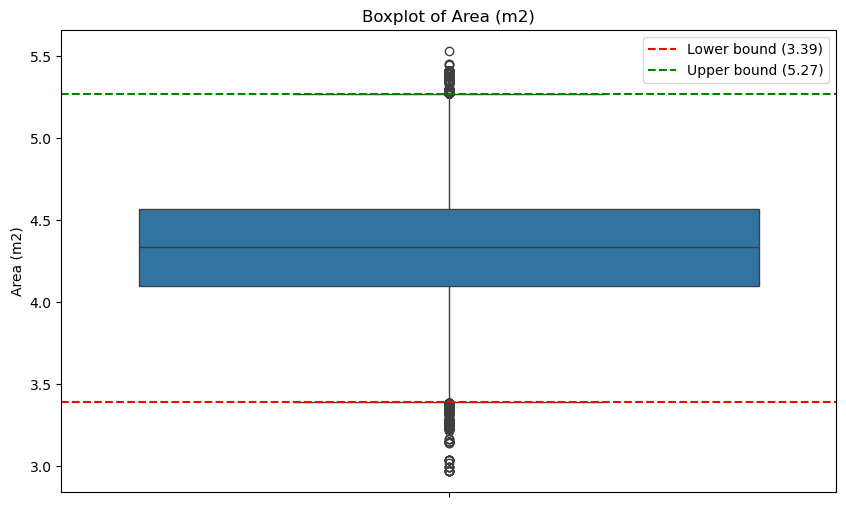

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_numerical_boxplots(df, save_plots=False, output_dir='./boxplots'):
    """
    Creates boxplots for all numerical variables in the DataFrame and displays outlier boundaries.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - save_plots (bool): If True, saves the plots to files instead of displaying them.
    - output_dir (str): The directory where plots will be saved if save_plots is True.

    Returns:
    - None
    """
    # Ensure the output directory exists
    if save_plots and not os.path.exists(output_dir):
        os.makedirs(output_dir)
        
    # Get list of numerical columns
    numerical_cols = df.select_dtypes(include=['float32', 'float64']).columns.tolist()
    
    for col in numerical_cols:
        plt.figure(figsize=(10, 6))
        sns.boxplot(y=df[col])
        plt.title(f'Boxplot of {col}')
        
        # Calculate Q1, Q3, and IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Add lines to show the outlier boundaries
        plt.axhline(lower_bound, color='red', linestyle='--', label=f'Lower bound ({lower_bound:.2f})')
        plt.axhline(upper_bound, color='green', linestyle='--', label=f'Upper bound ({upper_bound:.2f})')
        plt.legend()
        
        # Label the y-axis
        plt.ylabel(col)
        
        if save_plots:
            # Save the plot to the specified directory
            filename = f'boxplot_{col}.png'
            plt.savefig(os.path.join(output_dir, filename))
            plt.close()
            print(f"Saved boxplot for '{col}' as '{filename}'.")
        else:
            # Display the plot
            plt.show()


plot_numerical_boxplots(df)

### Heatmaps

Loading data...
Loaded parquet file from local path.
Loaded file: 'minimal_withoutfc_dupesdropped_frequencies_area_removedskew_outliers3_0_tn20_mcp00.10.parquet'
Preprocessing data...
Data preprocessing completed.


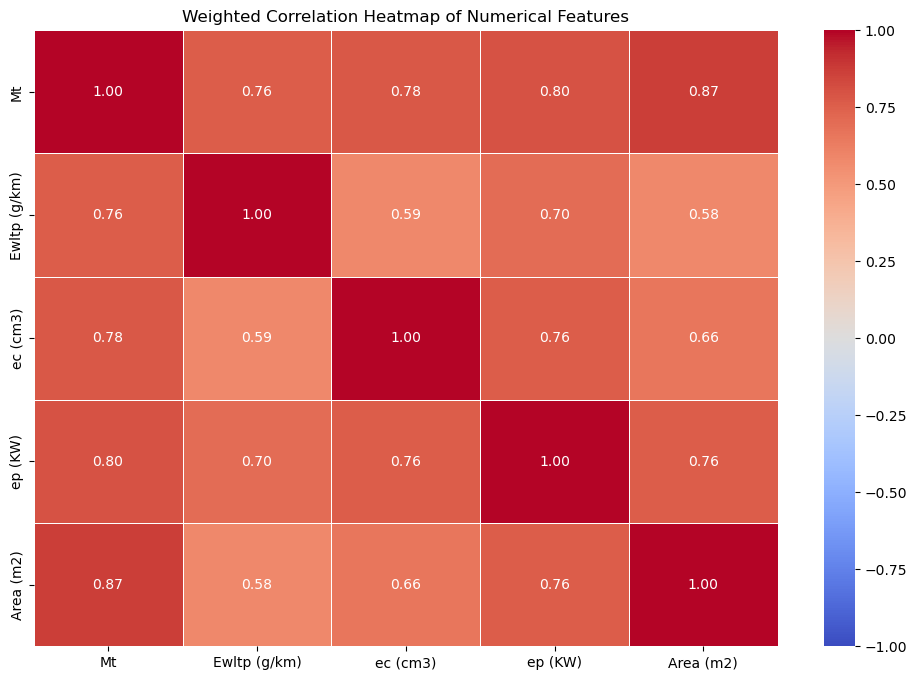

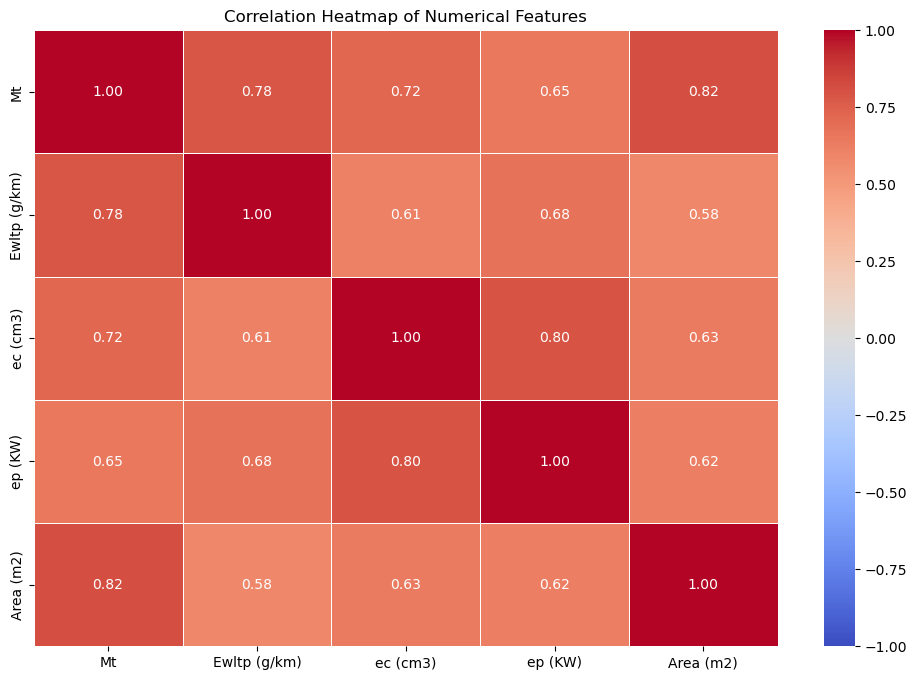

In [31]:
df = load_and_preprocess_data(dataset_number=69, columns_to_drop = ['W (mm)', 'At1 (mm)'])
collinearity_heatmap_weighted(df, weight_column='frequency')
collinearity_heatmap(df)

# 1.Z Load Alex df

In [ ]:

# The beginning of each section
# Loading the data frame

# Inspect the data frame
df = load_data_local('EU_all_current_shared.parquet', alex_path)


alex_path = r'C:\Users\alexa\Downloads\aug24_bds_int---co2\data' #Alex path
# Call the function to inspect your DataFrame
inspect_data(df)